In [1]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
import yaml
from pathlib import Path
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [2]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper Functions

In [5]:
## Load Config file for the strategy
def load_prod_strategy_config(strategy_version='v0.1.0'):
    nb_cwd = Path.cwd()  # git/trend_following/research/notebooks
    config_path = (
            nb_cwd.parents[1]  # -> git/trend_following
            / "live_strategy"
            / f"trend_following_strategy_{strategy_version}-live"
            / "config"
            / f"trend_strategy_config_{strategy_version}.yaml"
    )

    print(config_path)  # sanity check
    print(config_path.exists())  # should be True

    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    return cfg

In [6]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",      start_date),
            ("end_date",        end_date),
            ("warm_up_days",    WARMUP_DAYS),
            ("ticker_list",     ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("mavg_z_score_window",        mavg_z_score_window),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("log_std_window",               log_std_window),
            ("coef_of_variation_window",     coef_of_variation_window),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
            ("vol_of_vol_p_min",             vol_of_vol_p_min),
            ("r2_strong_threshold",          r2_strong_threshold)
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",             lower_r_sqr_limit),
            ("upper_r_sqr_limit",             upper_r_sqr_limit),
            ("rolling_r2_window",             rolling_r2_window),
            ("r2_smooth_window",              r2_smooth_window),
            ("r2_confirm_days",               r2_confirm_days),
            ("rolling_sharpe_window",         rolling_sharpe_window),
            ("use_activation",                use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
            ("weighted_signal_ewm_window",    weighted_signal_ewm_window)
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                  long_only),
            ("use_coinbase_data",          use_coinbase_data),
            ("use_saved_files",            use_saved_files),
            ("saved_file_end_date",        saved_file_end_date),
            ("use_specific_start_date",    use_specific_start_date),
            ("signal_start_date",          signal_start_date),
            ("price_or_returns_calc",      price_or_returns_calc),
            ("notional_threshold_pct",     notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
            ("warmup_days",                WARMUP_DAYS)
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [7]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

## Signal Performance

In [9]:
cfg = load_prod_strategy_config()

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.1.0-live/config/trend_strategy_config_v0.1.0.yaml
True


In [10]:
cfg

{'portfolio': {'exchange': 'Coinbase Advanced', 'name': 'Trend Following'},
 'run': {'start_date': '2022-04-01',
  'end_date': '2025-07-31',
  'use_specific_start_date': True,
  'signal_start_date': '2022-04-01',
  'warmup_days': 300,
  'long_only': True,
  'annual_trading_days': 365,
  'initial_capital': 15000},
 'universe': {'tickers': ['BTC-USD',
   'ETH-USD',
   'SOL-USD',
   'ADA-USD',
   'AVAX-USD']},
 'data': {'use_coinbase_data': True,
  'use_saved_files': True,
  'saved_file_end_date': '2025-07-31',
  'price_or_returns_calc': 'price',
  'moving_avg_type': 'exponential'},
 'signals': {'moving_average': {'fast_mavg': 20,
   'slow_mavg': 200,
   'mavg_stepsize': 8,
   'mavg_z_score_window': 126},
  'donchian': {'entry_rolling_donchian_window': 56,
   'exit_rolling_donchian_window': 28,
   'use_donchian_exit_gate': False},
  'weighting': {'ma_crossover_signal_weight': 0.85,
   'donchian_signal_weight': 0.15,
   'weighted_signal_ewm_window': 4},
  'activation': {'use_activation': F

In [11]:
import pandas as pd

# assume cfg is already loaded from YAML as shown in your message

# --- Prod Configuration (from cfg) ---
start_date  = pd.Timestamp(cfg['run']['start_date']).date()
end_date    = pd.Timestamp(cfg['run']['end_date']).date()
warmup_days = int(cfg['run']['warmup_days'])

ticker_list = list(cfg['universe']['tickers'])

# signals.moving_average
fast_mavg        = int(cfg['signals']['moving_average']['fast_mavg'])
slow_mavg        = int(cfg['signals']['moving_average']['slow_mavg'])
mavg_stepsize    = int(cfg['signals']['moving_average']['mavg_stepsize'])
mavg_z_score_window = int(cfg['signals']['moving_average']['mavg_z_score_window'])

# signals.donchian
entry_rolling_donchian_window = int(cfg['signals']['donchian']['entry_rolling_donchian_window'])
exit_rolling_donchian_window  = int(cfg['signals']['donchian']['exit_rolling_donchian_window'])
use_donchian_exit_gate        = bool(cfg['signals']['donchian']['use_donchian_exit_gate'])

# signals.weighting
ma_crossover_signal_weight = float(cfg['signals']['weighting']['ma_crossover_signal_weight'])
donchian_signal_weight     = float(cfg['signals']['weighting']['donchian_signal_weight'])
weighted_signal_ewm_window = int(cfg['signals']['weighting']['weighted_signal_ewm_window'])  # (new config but same value)

# signals.filters.rolling_r2
rolling_r2_window   = int(cfg['signals']['filters']['rolling_r2']['rolling_r2_window'])
lower_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit'])
upper_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit'])
r2_smooth_window    = int(cfg['signals']['filters']['rolling_r2']['r2_smooth_window'])
r2_confirm_days     = int(cfg['signals']['filters']['rolling_r2']['r2_confirm_days'])
r2_strong_threshold = float(cfg['signals']['filters']['rolling_r2']['r2_strong_threshold'])

# signals.filters.vol_of_vol
log_std_window            = int(cfg['signals']['filters']['vol_of_vol']['log_std_window'])
coef_of_variation_window  = int(cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window'])
vol_of_vol_z_score_window = int(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window'])
vol_of_vol_p_min          = float(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min'])

# signals.activation
use_activation              = bool(cfg['signals']['activation']['use_activation'])
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']  # likely None

# data / run toggles
moving_avg_type        = str(cfg['data']['moving_avg_type'])
long_only              = bool(cfg['run']['long_only'])
price_or_returns_calc  = str(cfg['data']['price_or_returns_calc'])

initial_capital        = float(cfg['run']['initial_capital'])

rolling_cov_window     = int(cfg['risk_and_sizing']['rolling_cov_window'])
volatility_window      = int(cfg['risk_and_sizing']['volatility_window'])

# stop loss strategy (new)
stop_loss_strategy     = str(cfg['risk_and_sizing']['stop_loss_strategy'])
rolling_atr_window     = int(cfg['risk_and_sizing']['rolling_atr_window'])
atr_multiplier         = float(cfg['risk_and_sizing']['atr_multiplier'])
highest_high_window    = int(cfg['risk_and_sizing']['highest_high_window'])

# cooldown (new)
cooldown_counter_threshold = int(cfg['execution_and_costs']['cooldown_counter_threshold'])

# target vol (new value)
annualized_target_volatility = float(cfg['risk_and_sizing']['annualized_target_volatility'])

transaction_cost_est   = float(cfg['execution_and_costs']['transaction_cost_est'])
passive_trade_rate     = float(cfg['execution_and_costs']['passive_trade_rate'])
notional_threshold_pct = float(cfg['execution_and_costs']['notional_threshold_pct'])

rolling_sharpe_window  = int(cfg['risk_and_sizing']['rolling_sharpe_window'])
cash_buffer_percentage = float(cfg['risk_and_sizing']['cash_buffer_percentage'])
annual_trading_days    = int(cfg['run']['annual_trading_days'])

use_coinbase_data      = bool(cfg['data']['use_coinbase_data'])
use_saved_files        = bool(cfg['data']['use_saved_files'])
saved_file_end_date    = str(cfg['data']['saved_file_end_date'])

use_specific_start_date = bool(cfg['run']['use_specific_start_date'])
signal_start_date       = pd.Timestamp(cfg['run']['signal_start_date']).date()


In [327]:
start_date

datetime.date(2022, 4, 1)

In [329]:
start_date - pd.Timedelta(days=warmup_days)

datetime.date(2021, 6, 5)

In [331]:
start_date = start_date
end_date = datetime.now(timezone.utc).date()#- pd.Timedelta(days=1)

In [333]:
end_date

datetime.date(2025, 11, 30)

In [335]:
ticker_list

['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

In [337]:
end_date_temp = pd.Timestamp('2025-07-31').date()

In [339]:
type(end_date_temp)

datetime.date

## Original Prod Config with Core L1 Coins

In [36]:
ticker_list

['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

In [38]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
df_final_prod_config = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_prod_config = df_final_prod_config[df_final_prod_config.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config = perf.calculate_asset_level_returns(df_final_prod_config, end_date_test, ticker_list)

portfolio_perf_metrics_prod_config = calculate_risk_and_performance_metrics(df_final_prod_config, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                            strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.3317590416631553,
 'annualized_sharpe_ratio': 1.4134421786840479,
 'calmar_ratio': 2.560309328537423,
 'annualized_std_dev': 0.4247262948243901,
 'max_drawdown': -0.12957771858475892,
 'max_drawdown_duration': Timedelta('283 days 00:00:00'),
 'hit_rate': 0.13717693836978131,
 't_statistic': 2.798163113836065,
 'p_value': 0.005237657951494762,
 'trade_count': 139.0}

<Axes: title={'center': '5 Coin Strategy Target Notional'}, xlabel='date'>

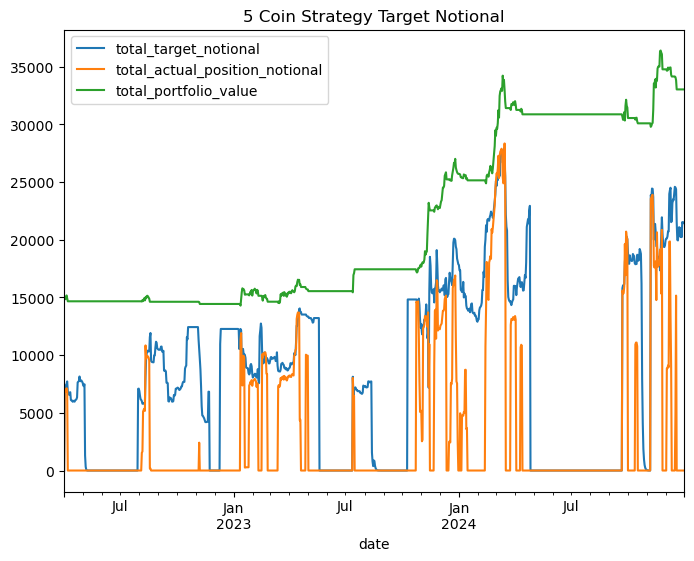

In [39]:
df_final_prod_config[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6), title='5 Coin Strategy Target Notional')

<Axes: xlabel='date'>

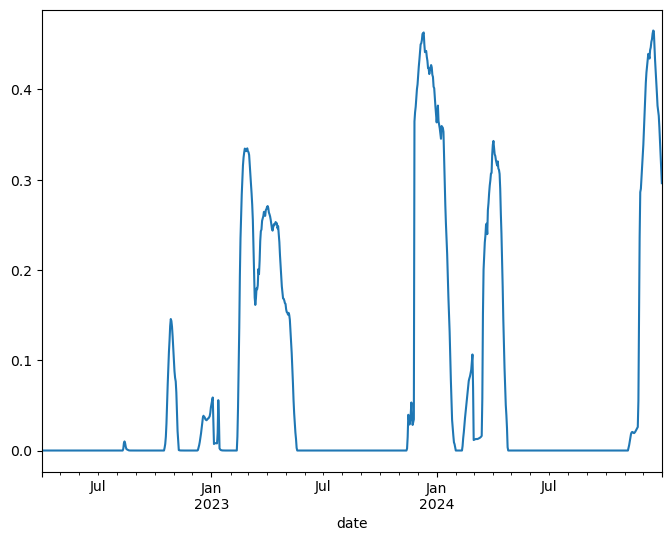

In [40]:
df_final_prod_config['BTC-USD_final_signal'].plot(figsize=(8,6))

<Axes: xlabel='date'>

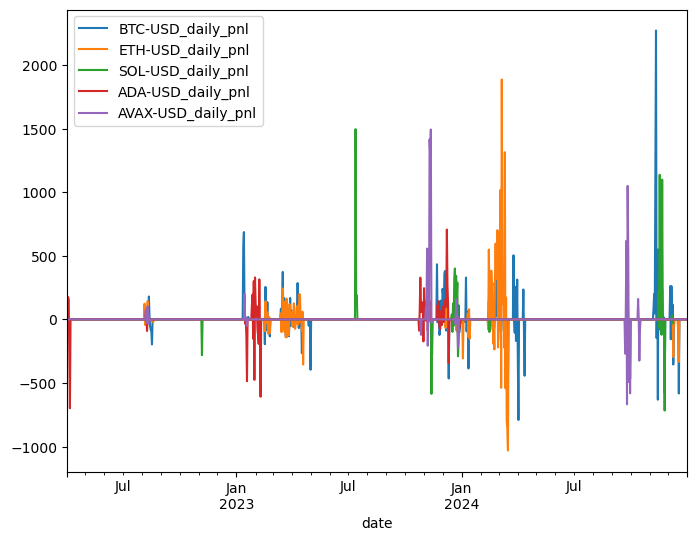

In [41]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in ticker_list]
df_final_prod_config[daily_pnl_cols].plot(figsize=(8,6))

In [57]:
final_weighted_additive_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
df_final_prod_config[((df_final_prod_config.index >= pd.Timestamp('2023-10-01')) &
                      (df_final_prod_config.index <= pd.Timestamp('2023-10-31')))][final_weighted_additive_signal_cols]

BTC-USD_final_weighted_additive_signal  \
date                                                 
2023-10-01                               -0.387492   
2023-10-02                               -0.369007   
2023-10-03                               -0.357815   
2023-10-04                               -0.348035   
2023-10-05                               -0.334373   
2023-10-06                               -0.323921   
2023-10-07                               -0.307568   
2023-10-08                               -0.292081   
2023-10-09                               -0.278553   
2023-10-10                               -0.270417   
2023-10-11                               -0.264304   
2023-10-12                               -0.264557   
2023-10-13                               -0.264751   
2023-10-14                               -0.263127   
2023-10-15                               -0.262527   
2023-10-16                               -0.257254   
2023-10-17                               -0.220524   
2023-10-18                               -0.213887   
2023-10-19                               -0.205134   
2023-10-20                               -0.187995   
2023-10-21                               -0.150239   
2023-10-22                               -0.114617   
2023-10-23                               -0.082271   
2023-10-24                               -0.027345   
2023-10-25                                0.023922   
2023-10-26                                0.088202   
2023-10-27                                0.145623   
2023-10-28                                0.194981   
2023-10-29                                0.240422   
2023-10-30                                0.285559   
2023-10-31                                0.321538   

            ETH-USD_final_weighted_additive_signal  \
date                                                 
2023-10-01                               -0.410644   
2023-10-02                               -0.390485   
2023-10-03                               -0.384545   
2023-10-04                               -0.379194   
2023-10-05                               -0.375332   
2023-10-06                               -0.379320   
2023-10-07                               -0.372291   
2023-10-08                               -0.368592   
2023-10-09                               -0.365033   
2023-10-10                               -0.375864   
2023-10-11                               -0.386200   
2023-10-12                               -0.393505   
2023-10-13                               -0.403567   
2023-10-14                               -0.406463   
2023-10-15                               -0.408181   
2023-10-16                               -0.408529   
2023-10-17                               -0.393713   
2023-10-18                               -0.395086   
2023-10-19                               -0.396039   
2023-10-20                               -0.394475   
2023-10-21                               -0.379734   
2023-10-22                               -0.362051   
2023-10-23                               -0.338162   
2023-10-24                               -0.286137   
2023-10-25                               -0.243550   
2023-10-26                               -0.212857   
2023-10-27                               -0.175338   
2023-10-28                               -0.143806   
2023-10-29                               -0.112520   
2023-10-30                               -0.076431   
2023-10-31                               -0.037489   

            SOL-USD_final_weighted_additive_signal  \
date                                                 
2023-10-01                               -0.145097   
2023-10-02                               -0.094254   
2023-10-03                               -0.052047   
2023-10-04                               -0.009342   
2023-10-05                                0.024455   
2023-10-06                                0.050193   
2023-10-07    

In [59]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
df_final_prod_config[((df_final_prod_config.index >= pd.Timestamp('2023-10-01')) &
                      (df_final_prod_config.index <= pd.Timestamp('2023-10-31')))][final_signal_cols]

BTC-USD_final_signal  ETH-USD_final_signal  SOL-USD_final_signal  \
date                                                                           
2023-10-01          0.000000e+00                   0.0          0.000000e+00   
2023-10-02          0.000000e+00                   0.0          0.000000e+00   
2023-10-03          0.000000e+00                   0.0          0.000000e+00   
2023-10-04          0.000000e+00                   0.0          0.000000e+00   
2023-10-05          0.000000e+00                   0.0          4.322411e-31   
2023-10-06          0.000000e+00                   0.0          4.435910e-31   
2023-10-07          0.000000e+00                   0.0          3.591226e-31   
2023-10-08          0.000000e+00                   0.0          2.385976e-31   
2023-10-09          0.000000e+00                   0.0          1.447284e-31   
2023-10-10          0.000000e+00                   0.0          7.633809e-32   
2023-10-11          0.000000e+00                   0.0          3.985097e-32   
2023-10-12          0.000000e+00                   0.0          2.084842e-32   
2023-10-13          0.000000e+00                   0.0          1.011882e-32   
2023-10-14          0.000000e+00                   0.0          5.129430e-33   
2023-10-15          0.000000e+00                   0.0          2.614530e-33   
2023-10-16          0.000000e+00                   0.0          2.289222e-33   
2023-10-17          0.000000e+00                   0.0          3.572946e-33   
2023-10-18          0.000000e+00                   0.0          4.168131e-33   
2023-10-19          0.000000e+00                   0.0          2.274496e-33   
2023-10-20          0.000000e+00                   0.0          1.269994e-33   
2023-10-21          0.000000e+00                   0.0          7.160339e-34   
2023-10-22          0.000000e+00                   0.0          4.052762e-34   
2023-10-23          0.000000e+00                   0.0          2.213790e-34   
2023-10-24          0.000000e+00                   0.0          1.226823e-34   
2023-10-25          1.173228e-06                   0.0          3.454231e-35   
2023-10-26          2.162852e-06                   0.0          3.673565e-36   
2023-10-27          1.785455e-06                   0.0          1.810660e-36   
2023-10-28          1.195310e-06                   0.0          9.288108e-37   
2023-10-29          7.369405e-07                   0.0          4.729122e-37   
2023-10-30          4.376462e-07                   0.0          2.420684e-37   
2023-10-31          2.463942e-07                   0.0          3.577713e-37   

            ADA-USD_final_signal  AVAX-USD_final_signal  
date                                                     
2023-10-01              0.000000               0.000000  
2023-10-02              0.000000               0.000000  
2023-10-03              0.000000               0.000000  
2023-10-04              0.000000               0.000000  
2023-10-05              0.000000               0.000000  
2023-10-06              0.000000               0.000000  
2023-10-07              0.000000               0.000000  
2023-10-08              0.000000               0.000000  
2023-10-09              0.000000               0.000000  
2023-10-10              0.002474               0.000000  
2023-10-11              0.007888               0.000000  
2023-10-12              0.013616               0.000000  
2023-10-13              0.016761               0.000000  
2023-10-14              0.019950               0.000000  
2023-10-15              0.026248               0.000000  
2023-10-16              0.033279               0.000000  
2023-10-17              0.048231               0.000000  
2023-10-18              0.052950               0.000000  
2023-10-19              0.048838               0.000000  
2023-10-20              0.054688               0.000000  
2023-10-21              0.070172               0.000000  
2023-10-22              0.096522     

In [61]:
## Code to generate Trend Following Signal with Moving Avg Crossover, Donchian Channel, Rolling R Squared and Vol of Vol Signals
def get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol_alt(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', use_coinbase_data=True, use_saved_files=True,
        saved_file_end_date='2025-07-31'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict

    for ticker in ticker_list:
        # Create Column Names
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        rolling_r2_col = f'{ticker}_rolling_r_sqr'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'

        # if pd.to_datetime(date_list[ticker]).date() > start_date:
        #     run_date = pd.to_datetime(date_list[ticker]).date()
        # else:
        #     run_date = start_date

        df_trend = tf.generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr_vol_of_vol(
            start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
            entry_rolling_donchian_window=entry_rolling_donchian_window,
            exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
            ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
            weighted_signal_ewm_window=weighted_signal_ewm_window,
            rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit,
            upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
            log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
            vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
            r2_strong_threshold=r2_strong_threshold,
            use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
            moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
            use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
            saved_file_end_date=saved_file_end_date)

        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col,
                      final_weighted_additive_signal_col,
                      rolling_r2_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

def apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', initial_capital=15000, rolling_cov_window=20,
        volatility_window=20, stop_loss_strategy='Chandelier', rolling_atr_window=20, atr_multiplier=0.5,
        highest_high_window=56, transaction_cost_est=0.001,
        passive_trade_rate=0.05, notional_threshold_pct=0.05, min_trade_notional_abs=10, cooldown_counter_threshold=3,
        use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31', rolling_sharpe_window=50,
        cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365,
        use_specific_start_date=False, signal_start_date=None):

    ## Check if data is available for all the tickers
    # date_list = cn.coinbase_start_date_by_ticker_dict
    # ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]

    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers

    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol_alt(
        start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
        long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
        use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window,
                                                                          annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date,
                                                        ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        highest_high_window=highest_high_window,
                                                        price_or_returns_calc='price',
                                                        use_coinbase_data=use_coinbase_data,
                                                        use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(
        df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
        stop_loss_strategy=stop_loss_strategy, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
        highest_high_window=highest_high_window,
        cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct, min_trade_notional_abs=min_trade_notional_abs,
        cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
        use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

## L1 Coin Performance Research

### L1 Coins Run 2

In [66]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
l1_ticker_list = ['DOT-USD','ATOM-USD','LTC-USD','ALGO-USD','XLM-USD']
df_final_l1_run_2 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=l1_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_l1_run_2 = df_final_l1_run_2[df_final_l1_run_2.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_l1_run_2 = perf.calculate_asset_level_returns(df_final_l1_run_2, end_date_test, l1_ticker_list)

portfolio_perf_metrics_l1_run_2 = calculate_risk_and_performance_metrics(df_final_l1_run_2, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                         strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_l1_run_2

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
DOT-USD
ATOM-USD
LTC-USD
ALGO-USD
XLM-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.03674368046743215,
 'annualized_sharpe_ratio': -0.00010409304664330481,
 'calmar_ratio': 0.2063826341973543,
 'annualized_std_dev': 0.38838302001126124,
 'max_drawdown': -0.17803668709982567,
 'max_drawdown_duration': Timedelta('388 days 00:00:00'),
 'hit_rate': 0.073558648111332,
 't_statistic': 0.503573641983973,
 'p_value': 0.6146713753586656,
 'trade_count': 95.0}

<Axes: title={'center': '5 Coin Strategy Target Notional'}, xlabel='date'>

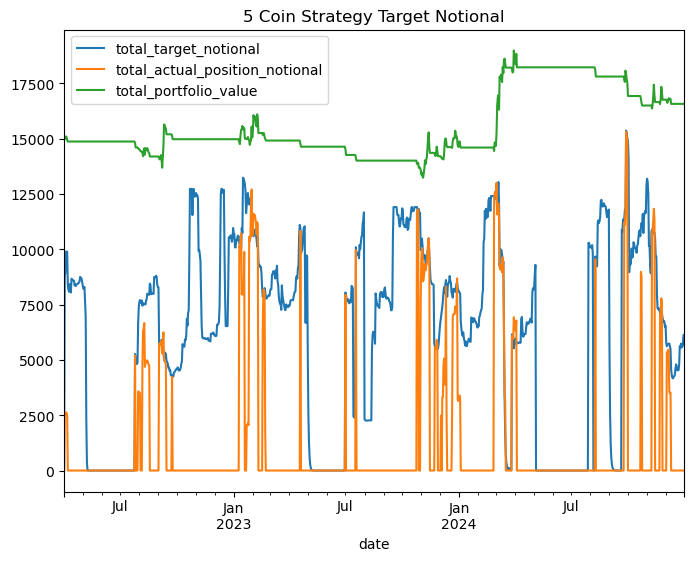

In [67]:
df_final_l1_run_2[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6), title='5 Coin Strategy Target Notional')

<Axes: xlabel='date'>

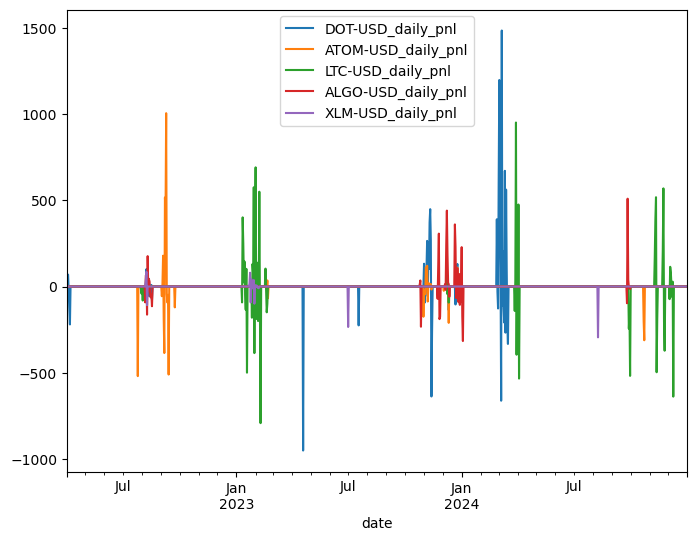

In [68]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in l1_ticker_list]
df_final_l1_run_2[daily_pnl_cols].plot(figsize=(8,6))

<Axes: xlabel='date'>

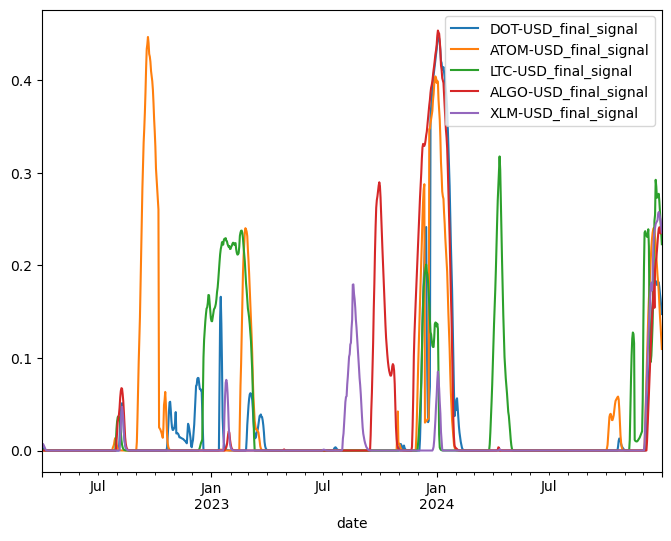

In [69]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in l1_ticker_list]
df_final_l1_run_2[final_signal_cols].plot(figsize=(8,6))

## L1 Alt Coins Performance Research

In [71]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
l1_alt_ticker_list = ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD']
df_final_l1_alt_run_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=l1_alt_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_l1_alt_run_1 = df_final_l1_alt_run_1[df_final_l1_alt_run_1.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_l1_alt_run_1 = perf.calculate_asset_level_returns(df_final_l1_alt_run_1, end_date_test, l1_alt_ticker_list)

portfolio_perf_metrics_l1_alt_run_1 = calculate_risk_and_performance_metrics(df_final_l1_alt_run_1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                             strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_l1_alt_run_1

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.29982672485875517,
 'annualized_sharpe_ratio': 1.0571489502659441,
 'calmar_ratio': 2.77421161922569,
 'annualized_std_dev': 0.7275517266101227,
 'max_drawdown': -0.10807637124035972,
 'max_drawdown_duration': Timedelta('246 days 00:00:00'),
 'hit_rate': 0.0775347912524851,
 't_statistic': 2.117381657848802,
 'p_value': 0.034472578644124,
 'trade_count': 93.0}

<Axes: xlabel='date'>

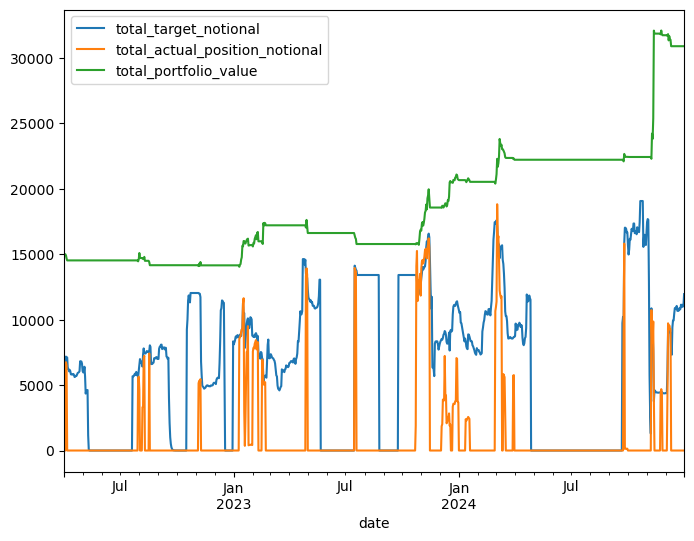

In [72]:
df_final_l1_alt_run_1[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6))

<Axes: xlabel='date'>

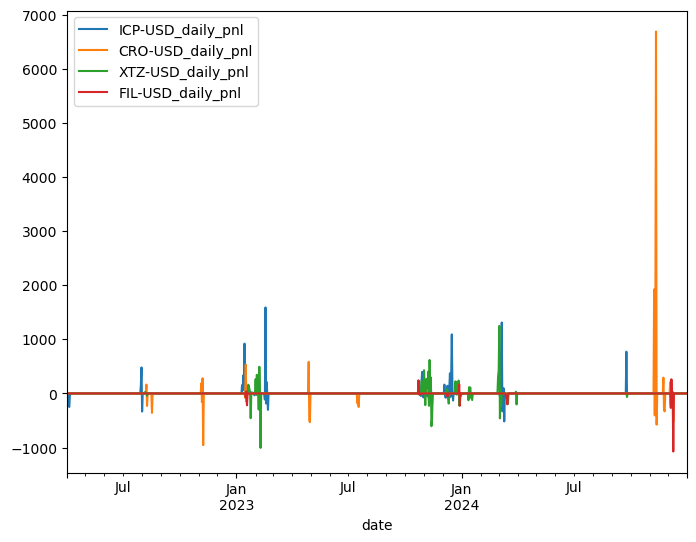

In [73]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in l1_alt_ticker_list]
df_final_l1_alt_run_1[daily_pnl_cols].plot(figsize=(8,6))

<Axes: xlabel='date'>

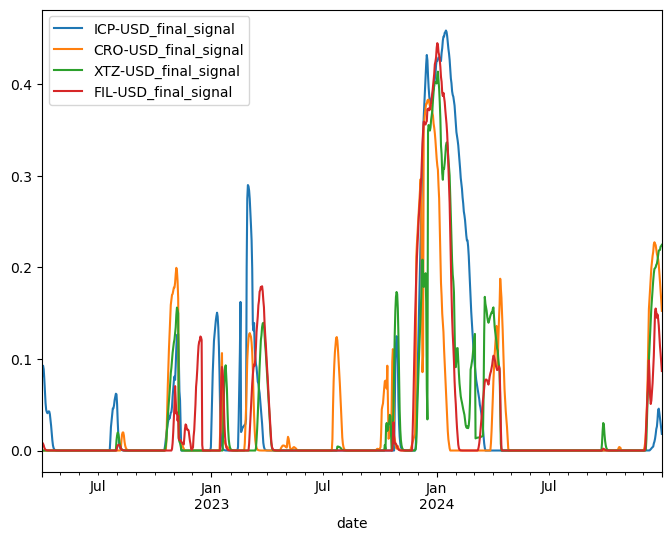

In [74]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in l1_alt_ticker_list]
df_final_l1_alt_run_1[final_signal_cols].plot(figsize=(8,6))

## L2 Coins Performance Research

In [ ]:
L1_ALT_TICKERS += [
    'SEI-USD',   # Sei
    'TIA-USD',   # Celestia
    'KAVA-USD',  # Kava
    'ROSE-USD',  # Oasis Network
    'CELO-USD',  # Celo (already on Coinbase as CGLD/CELO)
    'HNT-USD',   # Helium
    'MOBILE-USD',# Helium Mobile
    'RNDR-USD',  # Render (arguably “infra”, but L1-adj risk)
]
# That gives you 14; you can optionally keep one more from "Other" or AI/infra
# to make it exactly 15 if you want a full grid.


In [297]:
missing_l1_ticker_list = [
    'SEI-USD',   # Sei
    'TIA-USD',   # Celestia
    'KAVA-USD',  # Kava
    'ROSE-USD',  # Oasis Network
    'CELO-USD',  # Celo (already on Coinbase as CGLD/CELO)
    'HNT-USD',   # Helium
    'MOBILE-USD',# Helium Mobile
    'RNDR-USD',  # Render (arguably “infra”, but L1-adj risk)
]
missing_l1_ticker_start_date_dict = cn.determine_coinbase_start_date(ticker_list=missing_l1_ticker_list)

Checking data for SEI-USD: 2016-01-01 00:00:00
Data available from: 2023-08-15
First available date for SEI-USD: 2023-08-15
Checking data for TIA-USD: 2016-01-01 00:00:00
Data available from: 2023-11-01
First available date for TIA-USD: 2023-11-01
Checking data for KAVA-USD: 2016-01-01 00:00:00
Data available from: 2023-01-19
First available date for KAVA-USD: 2023-01-19
Checking data for ROSE-USD: 2016-01-01 00:00:00


2025-11-25 21:23:24 - coinbase.RESTClient - ERROR - HTTP Error: 400 Client Error: Bad Request {"error":"INVALID_ARGUMENT","error_details":"ProductID is invalid","message":"ProductID is invalid"}


Data available from: 2022-04-26
First available date for ROSE-USD: 2022-04-26
Checking data for CELO-USD: 2016-01-01 00:00:00
HTTPError encountered for CELO-USD. Skipping further checks.
No data available within the date range for CELO-USD.
Checking data for HNT-USD: 2016-01-01 00:00:00


2025-11-25 21:23:33 - coinbase.RESTClient - ERROR - HTTP Error: 400 Client Error: Bad Request {"error":"INVALID_ARGUMENT","error_details":"ProductID is invalid","message":"ProductID is invalid"}


Data available from: 2023-07-12
First available date for HNT-USD: 2023-07-12
Checking data for MOBILE-USD: 2016-01-01 00:00:00
HTTPError encountered for MOBILE-USD. Skipping further checks.
No data available within the date range for MOBILE-USD.
Checking data for RNDR-USD: 2016-01-01 00:00:00
Data available from: 2022-02-03
First available date for RNDR-USD: 2022-02-03


In [299]:
missing_l1_ticker_start_date_dict

{'SEI-USD': '2023-08-15',
 'TIA-USD': '2023-11-01',
 'KAVA-USD': '2023-01-19',
 'ROSE-USD': '2022-04-26',
 'CELO-USD': None,
 'HNT-USD': '2023-07-12',
 'MOBILE-USD': None,
 'RNDR-USD': '2022-02-03'}

In [105]:
missing_l2_ticker_list = ['ZK-USD','MNT-USD','MANTA-USD','LRC-USD','ZORA-USD','POL-USD','METIS-USD','STX-USD']
missing_l2_ticker_start_date_dict = cn.determine_coinbase_start_date(ticker_list=missing_l2_ticker_list)

Checking data for ZK-USD: 2016-01-01 00:00:00


2025-11-22 12:23:59 - coinbase.RESTClient - ERROR - HTTP Error: 400 Client Error: Bad Request {"error":"INVALID_ARGUMENT","error_details":"ProductID is invalid","message":"ProductID is invalid"}


Data available from: 2024-09-25
First available date for ZK-USD: 2024-09-25
Checking data for MNT-USD: 2016-01-01 00:00:00
HTTPError encountered for MNT-USD. Skipping further checks.
No data available within the date range for MNT-USD.
Checking data for MANTA-USD: 2016-01-01 00:00:00


2025-11-22 12:23:59 - coinbase.RESTClient - ERROR - HTTP Error: 400 Client Error: Bad Request {"error":"INVALID_ARGUMENT","error_details":"ProductID is invalid","message":"ProductID is invalid"}


HTTPError encountered for MANTA-USD. Skipping further checks.
No data available within the date range for MANTA-USD.
Checking data for LRC-USD: 2016-01-01 00:00:00
Data available from: 2020-09-15
First available date for LRC-USD: 2020-09-15
Checking data for ZORA-USD: 2016-01-01 00:00:00
Data available from: 2025-04-24
First available date for ZORA-USD: 2025-04-24
Checking data for POL-USD: 2016-01-01 00:00:00
Data available from: 2024-09-04
First available date for POL-USD: 2024-09-04
Checking data for METIS-USD: 2016-01-01 00:00:00
Data available from: 2022-06-28
First available date for METIS-USD: 2022-06-28
Checking data for STX-USD: 2016-01-01 00:00:00
Data available from: 2022-01-20
First available date for STX-USD: 2022-01-20


In [107]:
missing_l2_ticker_start_date_dict

{'ZK-USD': '2024-09-25',
 'MNT-USD': None,
 'MANTA-USD': None,
 'LRC-USD': '2020-09-15',
 'ZORA-USD': '2025-04-24',
 'POL-USD': '2024-09-04',
 'METIS-USD': '2022-06-28',
 'STX-USD': '2022-01-20'}

### L2 Coins First Ticker List

In [76]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
l2_ticker_list = ['SKL-USD','IMX-USD','LRC-USD','STX-USD']
df_final_l2_run_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=l2_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_l2_run_1 = df_final_l2_run_1[df_final_l2_run_1.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_l2_run_1 = perf.calculate_asset_level_returns(df_final_l2_run_1, end_date_test, l2_ticker_list)

portfolio_perf_metrics_l2_run_1 = calculate_risk_and_performance_metrics(df_final_l2_run_1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                         strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_l2_run_1

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
SKL-USD
IMX-USD
LRC-USD
STX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.21731440150665549,
 'annualized_sharpe_ratio': 0.9714601169122059,
 'calmar_ratio': 2.825807413853198,
 'annualized_std_dev': 0.39862159192765223,
 'max_drawdown': -0.07690347206299214,
 'max_drawdown_duration': Timedelta('263 days 00:00:00'),
 'hit_rate': 0.09045725646123261,
 't_statistic': 2.1002046785664215,
 'p_value': 0.035959585314616196,
 'trade_count': 86.0}

<Axes: xlabel='date'>

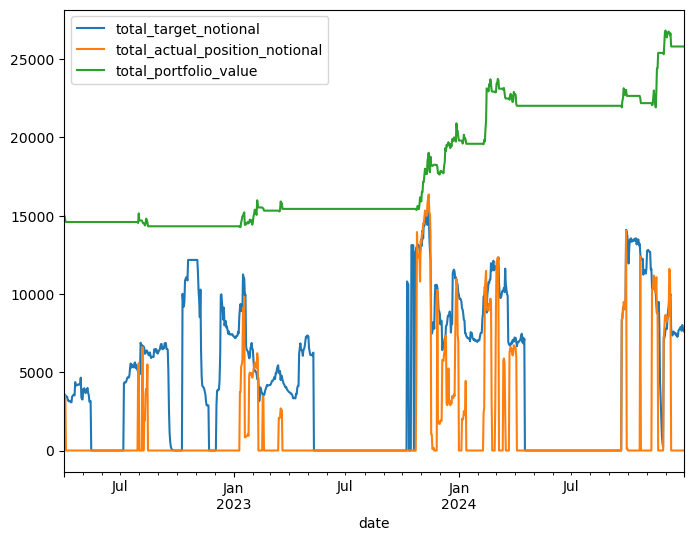

In [77]:
df_final_l2_run_1[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6))

<Axes: xlabel='date'>

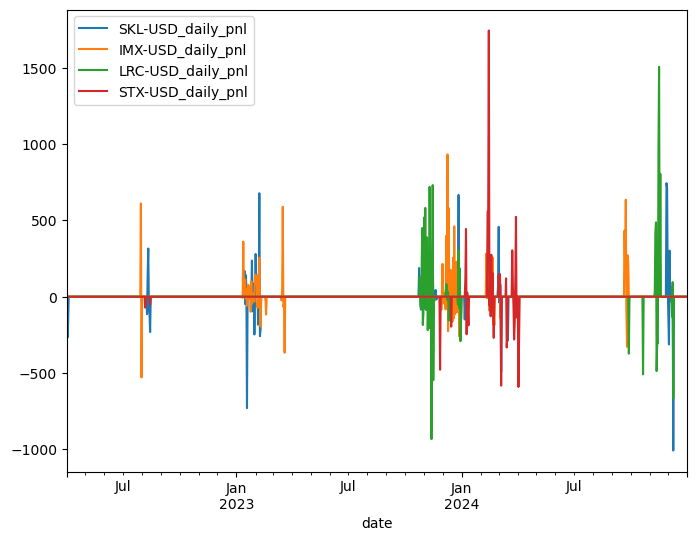

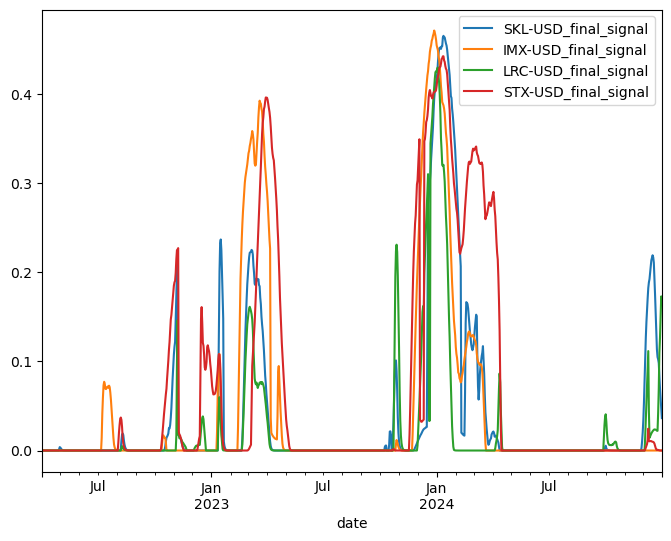

In [78]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in l2_ticker_list]
df_final_l2_run_1[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in l2_ticker_list]
df_final_l2_run_1[final_signal_cols].plot(figsize=(8,6))

## AI Coins Performance Research

In [80]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
ai_ticker_list = ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD']
df_final_ai_run_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=ai_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_ai_run_1 = df_final_ai_run_1[df_final_ai_run_1.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_ai_run_1 = perf.calculate_asset_level_returns(df_final_ai_run_1, end_date_test, ai_ticker_list)

portfolio_perf_metrics_ai_run_1 = calculate_risk_and_performance_metrics(df_final_ai_run_1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                         strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_ai_run_1

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
LINK-USD
FET-USD
GRT-USD
OXT-USD
KRL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.4268033329122023,
 'annualized_sharpe_ratio': 0.7025007091712941,
 'calmar_ratio': 2.0574684360055193,
 'annualized_std_dev': 2.203989120081168,
 'max_drawdown': -0.20744101121707675,
 'max_drawdown_duration': Timedelta('367 days 00:00:00'),
 'hit_rate': 0.06560636182902585,
 't_statistic': 1.3000643027956844,
 'p_value': 0.19387700877675926,
 'trade_count': 84.0}

<Axes: xlabel='date'>

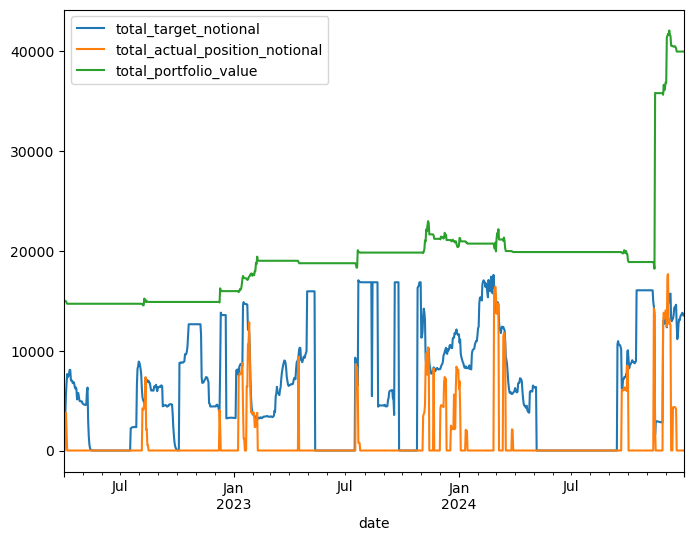

In [81]:
df_final_ai_run_1[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6))

<Axes: xlabel='date'>

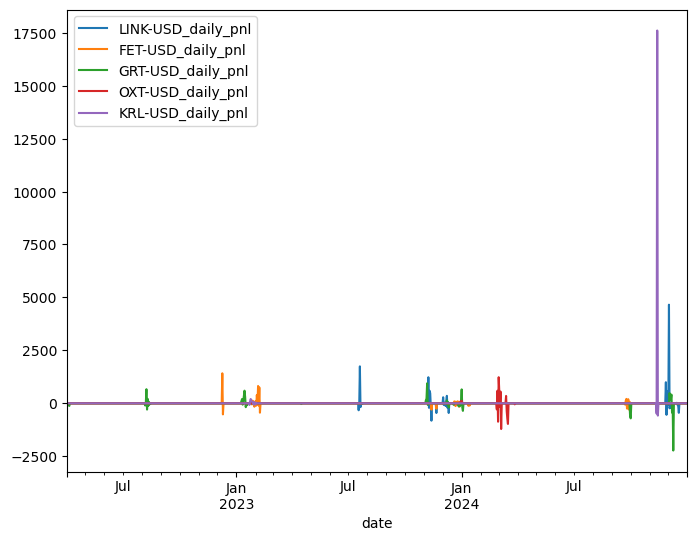

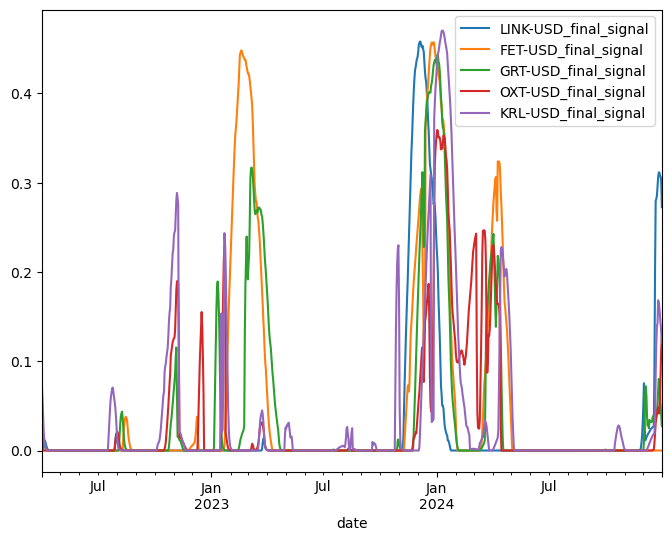

In [82]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in ai_ticker_list]
df_final_ai_run_1[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in ai_ticker_list]
df_final_ai_run_1[final_signal_cols].plot(figsize=(8,6))

## Defi Coins Performance Research

### Defi First Ticker Test

In [85]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
defi_ticker_list = ['UNI-USD','AAVE-USD','AMP-USD','COMP-USD','MKR-USD']
df_final_defi_run_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=defi_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_defi_run_1 = df_final_defi_run_1[df_final_defi_run_1.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_defi_run_1 = perf.calculate_asset_level_returns(df_final_defi_run_1, end_date_test, defi_ticker_list)

portfolio_perf_metrics_defi_run_1 = calculate_risk_and_performance_metrics(df_final_defi_run_1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                            strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_defi_run_1

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
UNI-USD
AAVE-USD
AMP-USD
COMP-USD
MKR-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.105842090379769,
 'annualized_sharpe_ratio': 0.35791522654686875,
 'calmar_ratio': 0.5473468018027549,
 'annualized_std_dev': 0.541911801709621,
 'max_drawdown': -0.1933729950210084,
 'max_drawdown_duration': Timedelta('421 days 00:00:00'),
 'hit_rate': 0.10039761431411531,
 't_statistic': 1.0089449254715865,
 'p_value': 0.3132438978924317,
 'trade_count': 109.0}

<Axes: xlabel='date'>

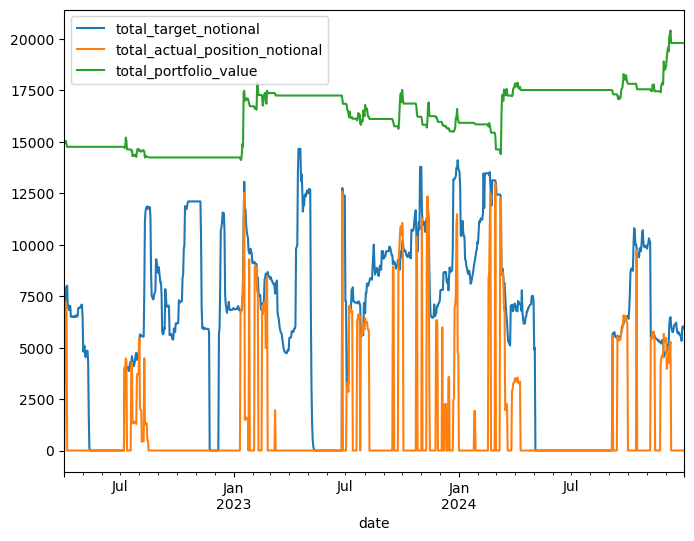

In [86]:
df_final_defi_run_1[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6))

<Axes: xlabel='date'>

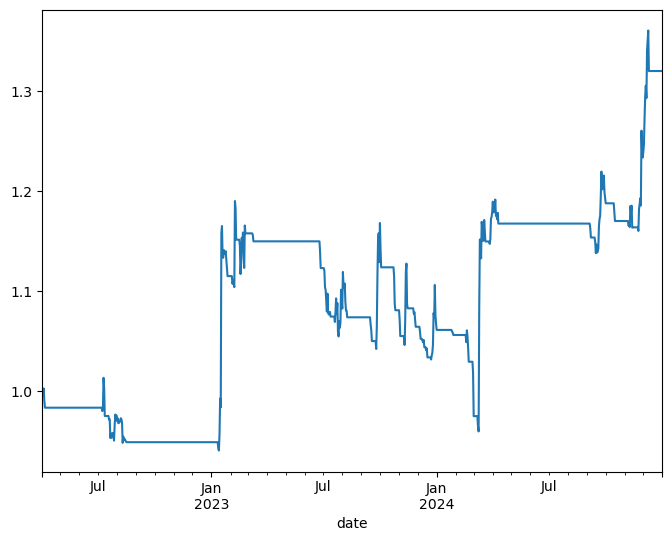

In [87]:
df_final_defi_run_1['equity_curve'].plot(figsize=(8,6))

<Axes: xlabel='date'>

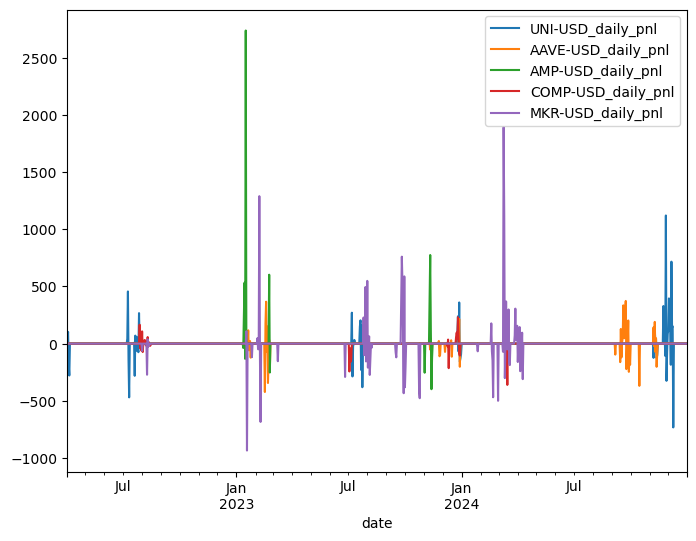

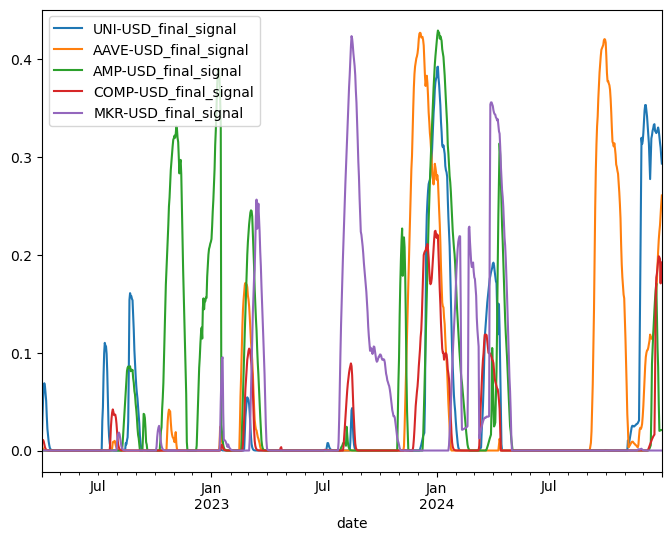

In [88]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in defi_ticker_list]
df_final_defi_run_1[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in defi_ticker_list]
df_final_defi_run_1[final_signal_cols].plot(figsize=(8,6))

### Defi Second Ticker List

In [ ]:
coinbase_start_date_by_ticker_dict = {
    ## L1 Major Coins
    'BTC-USD': '2016-01-01',  ## Core
    'ETH-USD': '2016-06-01',  ## Core
    'SOL-USD': '2021-06-01',  ## Core
    'ADA-USD': '2021-03-01',  ## Core
    'AVAX-USD': '2021-09-01', ## Core
    'DOT-USD': '2021-06-01',  ## L1 Major Run 2
    'ATOM-USD': '2020-01-01', ## L1 Major Run 2
    'LTC-USD': '2016-09-01',  ## L1 Major Run 2
    'XRP-USD': '2023-06-01',
    'ALGO-USD': '2019-08-01', ## L1 Major Run 2
    'XLM-USD': '2019-02-01',  ## L1 Major Run 2

    ## L1 Alt Coins
    'TON-USD': '2025-11-18',
    'NEAR-USD': '2022-09-01',
    'ICP-USD': '2021-05-10',  ## L1 Alt Run 1
    'HBAR-USD': '2022-10-13',
    'SUI-USD': '2023-05-18',
    'CRO-USD': '2021-11-01',  ## L1 Alt Run 1
    'APT-USD': '2022-10-19',
    'XTZ-USD': '2019-08-06',  ## L1 Alt Run 1
    'EGLD-USD': '2022-12-07',
    'FIL-USD': '2020-12-09',  ## L1 Alt Run 1
    'SEI-USD': '2023-08-15',
    'TIA-USD': '2023-11-01',
    'KAVA-USD': '2023-01-19',
    'ROSE-USD': '2022-04-26',

    ## L2 Coins
    'MATIC-USD': '2021-02-01', ## L2 Run 1
    'SKL-USD': '2021-02-01',   ## L2 Run 1
    'OP-USD': '2022-06-01',
    'ARB-USD': '2023-03-23',
    'POL-USD': '2024-09-04',
    'IMX-USD': '2021-12-09',   ## L2 Run 1
    'STRK-USD': '2024-02-21',
    'BLAST-USD': '2024-06-26',
    'ZK-USD': '2024-09-25',
    'LRC-USD': '2020-09-15',   ## L2 Run 1
    'ZORA-USD': '2025-04-24',
    'METIS-USD': '2022-06-28',
    'STX-USD': '2022-01-20',   ## L2 Run 1

    ## Meme Coins
    'DOGE-USD': '2021-06-01',
    'SHIB-USD': '2021-08-01',

    ## AI / Data / Infra Coins
    'LINK-USD': '2019-06-01',  ## AI Run 1
    'FET-USD': '2021-07-01',   ## AI Run 1
    'GRT-USD': '2020-12-01',   ## AI Run 1
    'RNDR-USD': '2022-02-03',
    'OXT-USD': '2019-12-01',   ## AI Run 1
    'AIOZ-USD': '2022-02-01',
    'MOBILE-USD': '2024-02-01',
    'HNT-USD': '2023-06-01',
    'DIA-USD': '2022-01-25',
    'KRL-USD': '2021-10-01',   ## AI Run 1
    'ZRO-USD': '2024-06-01',

    ## Stable Coins
    'USDT-USD': '2021-05-04',
    'DAI-USD': '2020-04-01',
    'USD1-USD': '2025-08-21',
    'PAX-USD': '2021-07-27',

    ## Defi Coins
    'UNI-USD': '2020-09-01',   ## Defi Run 1
    'AAVE-USD': '2020-12-01',  ## Defi Run 1
    'AMP-USD': '2021-05-01',   ## Defi Run 1
    'COMP-USD': '2020-06-23',  ## Defi Run 1
    'LDO-USD': '2022-11-17',
    'MKR-USD': '2020-06-09',   ## Defi Run 1
    'SNX-USD': '2020-12-15',   ## Defi Run 2
    'INJ-USD': '2022-09-20',
    'SUSHI-USD': '2021-03-11', ## Defi Run 2
    'CRV-USD': '2021-03-25',   ## Defi Run 2
    'BAL-USD': '2020-10-06',   ## Defi Run 2
    '1INCH-USD': '2021-04-09', ## Defi Run 2
    'RPL-USD': '2022-12-08',   
    'RSR-USD': '2025-04-22',
    'ONDO-USD': '2024-01-22',
    'ETHFI-USD': '2025-02-06',

    ## Other Coins
    'MANA-USD': '2021-04-01',
    'REQ-USD': '2021-07-01',
    'HONEY-USD': '2024-01-01'
}

In [89]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
defi_ticker_list_2 = ['SNX-USD','SUSHI-USD','CRV-USD','BAL-USD','1INCH-USD']
df_final_defi_run_2 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=defi_ticker_list_2, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_defi_run_2 = df_final_defi_run_2[df_final_defi_run_2.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_defi_run_2 = perf.calculate_asset_level_returns(df_final_defi_run_2, end_date_test, defi_ticker_list_2)

portfolio_perf_metrics_defi_run_2 = calculate_risk_and_performance_metrics(df_final_defi_run_2, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_defi_run_2

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
SNX-USD
SUSHI-USD
CRV-USD
BAL-USD
1INCH-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.01181962144359261,
 'annualized_sharpe_ratio': -0.1820463568477738,
 'calmar_ratio': 0.08516058666000371,
 'annualized_std_dev': 0.3935929935515842,
 'max_drawdown': -0.1387921561740929,
 'max_drawdown_duration': Timedelta('668 days 00:00:00'),
 'hit_rate': 0.08449304174950298,
 't_statistic': 0.2522756024022899,
 'p_value': 0.8008796280739587,
 'trade_count': 103.0}

<Axes: xlabel='date'>

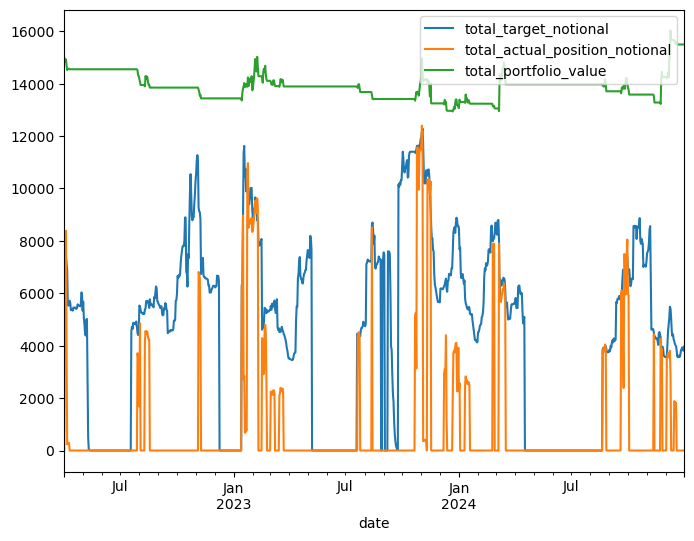

In [90]:
df_final_defi_run_2[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6))

<Axes: xlabel='date'>

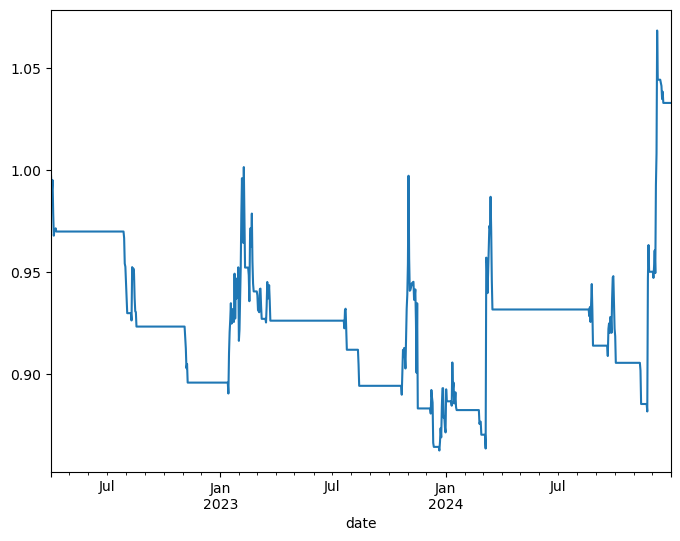

In [91]:
df_final_defi_run_2['equity_curve'].plot(figsize=(8,6))

<Axes: xlabel='date'>

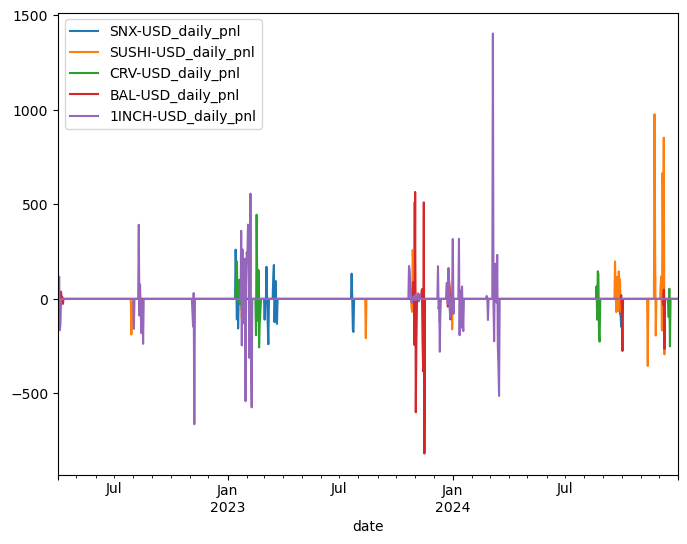

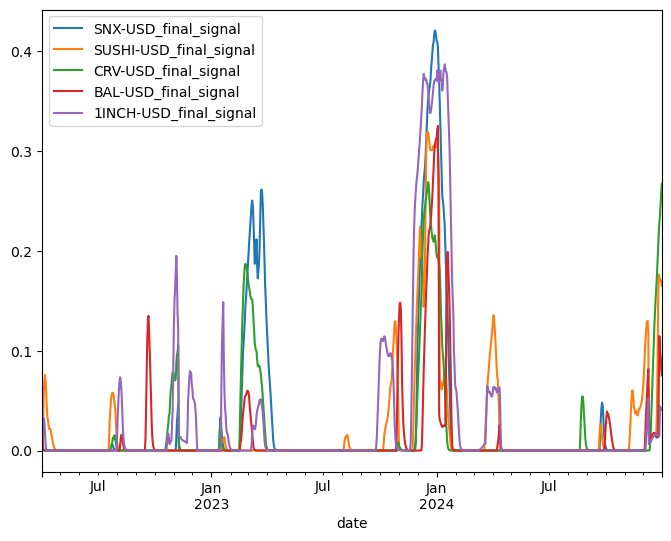

In [92]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in defi_ticker_list_2]
df_final_defi_run_2[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in defi_ticker_list_2]
df_final_defi_run_2[final_signal_cols].plot(figsize=(8,6))

## Cluster Level Portfolio Analysis

In [117]:
ANN_DAYS = 365
ASSET_RET_SUFFIX = "_daily_pct_returns"  # if you need asset-level stuff later

# 1. Put all your sleeve DFs in a dict
sleeves = {
    "core_L1_run1": df_final_prod_config,   # BTC/ETH/SOL/ADA/AVAX
    "L1_run2":      df_final_l1_run_2,
    "L1_alt_run1":  df_final_l1_alt_run_1,
    "L2_run1":      df_final_l2_run_1,
    "AI_run1":      df_final_ai_run_1,
    "DeFi_run1":    df_final_defi_run_1,
    "DeFi_run2":    df_final_defi_run_2
}

# 2. Build DataFrames of daily portfolio returns and position counts per sleeve
sleeve_ret = pd.concat(
    {name: df["portfolio_daily_pct_returns"] for name, df in sleeves.items()},
    axis=1
).dropna(how="all")
sleeve_ret.columns = sleeve_ret.columns.get_level_values(0)

sleeve_count = pd.concat(
    {name: df["count_of_positions"] for name, df in sleeves.items()},
    axis=1
).reindex(index=sleeve_ret.index)  # align with returns
sleeve_count.columns = sleeve_count.columns.get_level_values(0)

# 3. Correlation matrix between sleeves (unchanged)
sleeve_corr = sleeve_ret.corr()

# 4. Function to compute combined sleeve portfolio with arbitrary weights
def combine_sleeves(sleeve_ret, sleeve_count, weights):
    """
    sleeve_ret:   DataFrame [date x sleeve_name] of daily portfolio returns by sleeve
    sleeve_count: DataFrame [date x sleeve_name] of count_of_positions by sleeve
    weights:      dict {sleeve_name: weight} (will be normalized)
    """
    w = pd.Series(weights, dtype=float)
    w = w / w.sum()

    # Combined returns: weighted sum of sleeve returns
    combined_ret = (sleeve_ret[w.index] * w).sum(axis=1)

    # Combined "active day" indicator: any sleeve has positions
    # You can keep it as a count if you want, but for your vol filter
    # only != 0 matters.
    combined_count = (sleeve_count[w.index] != 0).any(axis=1).astype(int)

    return combined_ret, combined_count

def summarize_strategy(daily_ret, trade_count, ann_days=ANN_DAYS):
    """
    daily_ret:   pd.Series of portfolio_daily_pct_returns
    trade_count: pd.Series of count_of_positions (same index as daily_ret)
    """

    tmp = pd.DataFrame(
        {
            "portfolio_daily_pct_returns": daily_ret,
            "count_of_positions": trade_count,
        }
    )

    perf_metrics = perf.calculate_risk_and_performance_metrics(
        tmp,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,   # no TC adjustment for this combined series
        transaction_cost_est=0.0,
        passive_trade_rate=0.0,
        annual_trading_days=ann_days,
    )

    return {
        "annualized_return":       perf_metrics["annualized_return"],
        "annualized_std_dev":      perf_metrics["annualized_std_dev"],
        "annualized_sharpe_ratio": perf_metrics["annualized_sharpe_ratio"],
        "max_drawdown":            perf_metrics["max_drawdown"],
    }


In [119]:
## Sleeve Stats
sleeve_stats = {}
for name, df in sleeves.items():
    stats = summarize_strategy(
        daily_ret=df["portfolio_daily_pct_returns"],
        trade_count=df["count_of_positions"],
    )
    sleeve_stats[name] = stats

pd.DataFrame(sleeve_stats).T


annualized_return  annualized_std_dev  annualized_sharpe_ratio  \
core_L1_run1           0.331759            0.424726                 1.413442   
L1_run2                0.036744            0.388383                -0.000104   
L1_alt_run1            0.299827            0.727552                 1.057149   
L2_run1                0.217314            0.398622                 0.971460   
AI_run1                0.426803            2.203989                 0.702501   
DeFi_run1              0.105842            0.541912                 0.357915   
DeFi_run2              0.011820            0.393593                -0.182046   

              max_drawdown  
core_L1_run1     -0.129578  
L1_run2          -0.178037  
L1_alt_run1      -0.108076  
L2_run1          -0.076903  
AI_run1          -0.207441  
DeFi_run1        -0.193373  
DeFi_run2        -0.138792

In [199]:
sleeve_ret.head()

core_L1_run1  L1_run2   L1_run3  L1_large   L2_run1  DeFi_run1  \
date                                                                         
2022-04-01      0.000000      0.0  0.000000  0.000000  0.000000   0.000000   
2022-04-02     -0.005886      0.0  0.000000  0.000000 -0.003039  -0.005616   
2022-04-03     -0.003868      0.0  0.000000  0.000000 -0.017926   0.002273   
2022-04-04      0.011847      0.0 -0.005787 -0.002632 -0.006794   0.008315   
2022-04-05      0.010064      0.0 -0.015382 -0.006973  0.000000  -0.011246   

            DeFi_run2  DeFi_run3  DeFi_run4  
date                                         
2022-04-01        0.0   0.000000   0.000000  
2022-04-02        0.0  -0.004738  -0.005995  
2022-04-03        0.0   0.004181  -0.006820  
2022-04-04        0.0   0.018773   0.015622  
2022-04-05        0.0  -0.011704  -0.020282

<Axes: xlabel='date'>

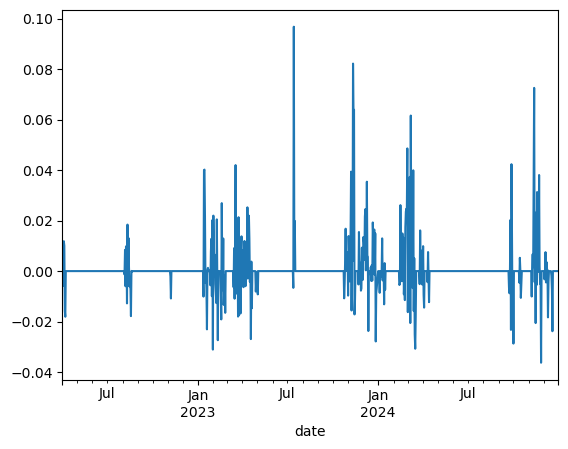

In [201]:
sleeve_ret['core_L1_run1'].plot()

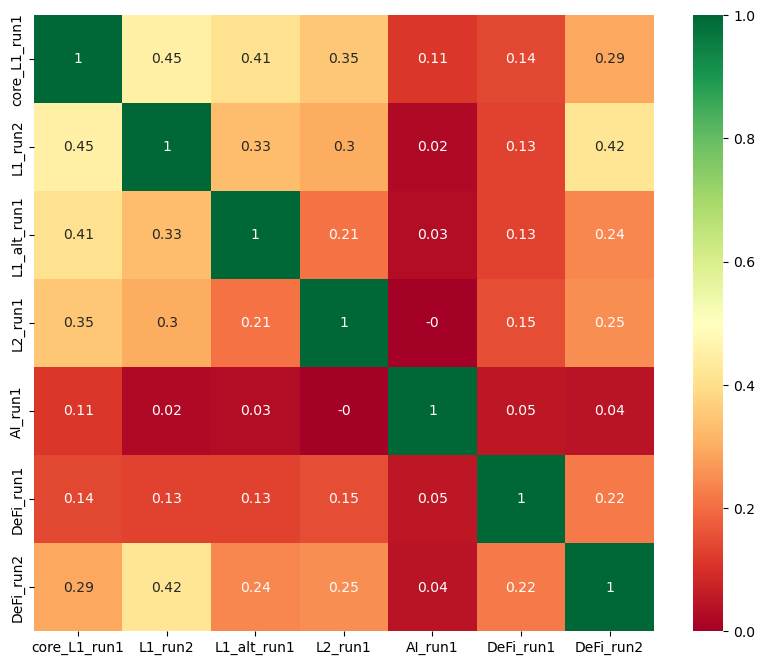

In [121]:
import seaborn as sns
plt.figure(figsize=(10, 8))
_ = sns.heatmap(sleeve_corr.round(decimals=2), annot=True, cmap='RdYlGn')
plt.show()

### Combined Portfolio Sample Performance

In [217]:
def portfolio_stats(sleeve_weights, sleeve_returns, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05):
    """
    Return (annualized_return, annualized_std_dev, annualized_sharpe_ratio)
    computed using *the same logic* as summarize_strategy /
    calculate_risk_and_performance_metrics.
    """
    sleeve_weights = np.array(sleeve_weights)

    # Daily portfolio return series
    port_daily_ret = (sleeve_returns[live_sleeves] @ sleeve_weights).rename("portfolio_daily_pct_returns")

    # Dummy trade-count series: Sharpe/stddev don't use it when
    # include_transaction_costs_and_fees=False, so 1 is fine.
    tmp = pd.DataFrame(
        {
            "portfolio_daily_pct_returns": port_daily_ret,
            "count_of_positions": 1,
        }
    )

    perf_metrics = perf.calculate_risk_and_performance_metrics(
        tmp,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        annual_rf=annual_rf,
        annual_trading_days=ann_days,
        include_transaction_costs_and_fees=False,  # match your summarize_strategy usage
        transaction_cost_est=0.0,
        passive_trade_rate=0.0,
    )

    return (
        perf_metrics["annualized_return"],
        perf_metrics["annualized_std_dev"],
        perf_metrics["annualized_sharpe_ratio"],
    )

def neg_sharpe(sleeve_weights, sleeve_returns, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05):
    return -portfolio_stats(sleeve_weights, sleeve_returns, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)[2]  # index 2 = annualized_sharpe_ratio

In [219]:
## Core Config Performance
core_df = df_final_prod_config

core_stats = summarize_strategy(
    daily_ret=core_df["portfolio_daily_pct_returns"],
    trade_count=core_df["count_of_positions"],
)
core_stats
# should match portfolio_perf_metrics_prod_config_test for the core run


{'annualized_return': 0.3317590416631553,
 'annualized_std_dev': 0.4247262948243901,
 'annualized_sharpe_ratio': 1.4134421786840479,
 'max_drawdown': -0.12957771858475892}

In [127]:
sleeve_weights = {
    "core_L1_run1": 0.50,   # BTC/ETH/SOL/ADA/AVAX
    "L1_run2":      0.00,
    "L1_alt_run1":  0.20,
    "L2_run1":      0.20,
    "AI_run1":      0.10,
    "DeFi_run1":    0.00,
    "DeFi_run2":    0.00
}

combined_ret, combined_count = combine_sleeves(sleeve_ret, sleeve_count, sleeve_weights)
combined_stats = summarize_strategy(combined_ret, combined_count)
combined_stats

{'annualized_return': 0.33210068906466184,
 'annualized_std_dev': 0.2643242816795903,
 'annualized_sharpe_ratio': 1.6709973021824138,
 'max_drawdown': -0.08889379789892132}

In [265]:
## Combined Portfolio Sample - Equal Weight
live_sleeves = ['core_L1_run1', 'L1_alt_run1', 'L2_run1', 'AI_run1']
sleeve_weights_list = [0.25, 0.25, 0.25, 0.25]
portfolio_stats(sleeve_weights_list, sleeve_ret, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

(0.35168508096736595, 0.19013872669613052, 1.415612517623156)

In [225]:
## Portfolio with No Diversification, just the Core Coin Config
live_sleeves = ['core_L1_run1', 'L1_alt_run1', 'L2_run1', 'AI_run1']
sleeve_weights_list = [1.0, 0.0, 0.0, 0.0]
portfolio_stats(sleeve_weights_list, sleeve_ret, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

(0.3317590416631553, 0.17937067325031214, 1.4134421786840479)

In [279]:
from scipy.optimize import minimize

# -------------------------------------------------------------------
# SciPy optimization with different core upper bounds
# -------------------------------------------------------------------

# Example: sleeves you’re including in the optimization
# live_sleeves order must match the columns of `sleeve_returns`
live_sleeves = ["core_L1_run1", "L1_alt_run1", "L2_run1", "AI_run1"]  # adjust to your keys
n_sleeves = len(live_sleeves)

# Name of the core sleeve and its index
CORE_NAME = "core_L1_run1"                         # adjust if different
core_idx = live_sleeves.index(CORE_NAME)

# Common constraints:
# 1) Sum of weights == 1
# 2) Core weight >= 0.40
constraints = [
    {"type": "eq",   "fun": lambda w: np.sum(w) - 1.0},
    {"type": "ineq", "fun": lambda w, idx=core_idx: w[idx] - 0.40},
]

def make_initial_guess(core_idx, n, core_min=0.40):
    """
    Simple feasible starting point:
    - core at core_min
    - remaining capital equally split across non-core sleeves
    """
    w0 = np.full(n, (1.0 - core_min) / (n - 1))
    w0[core_idx] = core_min
    return w0

def make_bounds(core_idx, core_max, other_max=0.5):
    """
    Build bounds list for minimize:
    - core in [0, core_max] but with separate constraint enforcing >= 0.40
    - others in [0, other_max]
    """
    bnds = []
    for i in range(n_sleeves):
        if i == core_idx:
            bnds.append((0.0, core_max))
        else:
            bnds.append((0.0, other_max))
    return bnds

def run_optimization_for_core_max(core_max, sleeve_returns, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05):
    """
    Run max-Sharpe optimization for a given core upper bound.
    """
    n_sleeves = len(live_sleeves)
    w0 = make_initial_guess(core_idx, n_sleeves, core_min=0.40)
    bounds = make_bounds(core_idx, core_max=core_max, other_max=0.5)

    res = minimize(
        neg_sharpe,
        w0,
        args=(sleeve_returns, live_sleeves, ann_days, annual_rf),
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"disp": False},
    )

    w_opt = res.x
    ann_ret, ann_vol, ann_sharpe = portfolio_stats(w_opt, sleeve_returns, live_sleeves, ann_days=ann_days, annual_rf=annual_rf)

    return pd.Series(w_opt, index=live_sleeves, name=f"weights_core_max_{core_max}"), (ann_ret, ann_vol, ann_sharpe), res

# -------------------------------------------------------------------
# Run the three requested scenarios
# -------------------------------------------------------------------

# sleeve_returns should be a DataFrame with columns = live_sleeves
# e.g. df_sleeve_rets with daily sleeve portfolio returns
# sleeve_returns = df_sleeve_rets   # whatever you named it

weights_050, stats_050, res_050 = run_optimization_for_core_max(core_max=0.50, sleeve_returns=sleeve_ret, live_sleeves=live_sleeves)
weights_100, stats_100, res_100 = run_optimization_for_core_max(core_max=1.00, sleeve_returns=sleeve_ret, live_sleeves=live_sleeves)
weights_080, stats_080, res_080 = run_optimization_for_core_max(core_max=0.80, sleeve_returns=sleeve_ret, live_sleeves=live_sleeves)

live_sleeves = ['core_L1_run1', 'L1_run2', 'L1_alt_run1', 'L2_run1', 'AI_run1', 'DeFi_run1', 'DeFi_run2']
n_sleeves = len(live_sleeves)
weights_all_080, stats_all_080, res_all_080 = run_optimization_for_core_max(core_max=0.80, sleeve_returns=sleeve_ret, live_sleeves=live_sleeves)

def fmt_weights(w):
    # Works for dicts, pandas Series, or any mapping-like object
    return {k: f"{float(v):.2%}" for k, v in w.items()}

def fmt_stats(s):
    # Expecting (ann_ret, ann_vol, ann_sharpe)
    ann_ret, ann_vol, ann_sharpe = s
    return (f"{float(ann_ret):.3%}", f"{float(ann_vol):.3%}", f"{float(ann_sharpe):.3f}")

print("=== Core max 0.50 ===")
print(fmt_weights(weights_050))
print("ann_ret, ann_vol, ann_sharpe:", fmt_stats(stats_050))

print("\n=== Core max 1.00 ===")
print(fmt_weights(weights_100))
print("ann_ret, ann_vol, ann_sharpe:", fmt_stats(stats_100))

print("\n=== Core max 0.80 ===")
print(fmt_weights(weights_080))
print("ann_ret, ann_vol, ann_sharpe:", fmt_stats(stats_080))

print("\n=== Core max 0.80 with all sleeves ===")
print(fmt_weights(weights_all_080))
print("ann_ret, ann_vol, ann_sharpe:", fmt_stats(stats_all_080))

=== Core max 0.50 ===
{'core_L1_run1': '44.28%', 'L1_alt_run1': '20.50%', 'L2_run1': '27.15%', 'AI_run1': '8.07%'}
ann_ret, ann_vol, ann_sharpe: ('32.009%', '14.201%', '1.682')

=== Core max 1.00 ===
{'core_L1_run1': '44.28%', 'L1_alt_run1': '20.50%', 'L2_run1': '27.15%', 'AI_run1': '8.07%'}
ann_ret, ann_vol, ann_sharpe: ('32.009%', '14.201%', '1.682')

=== Core max 0.80 ===
{'core_L1_run1': '44.28%', 'L1_alt_run1': '20.50%', 'L2_run1': '27.15%', 'AI_run1': '8.07%'}
ann_ret, ann_vol, ann_sharpe: ('32.009%', '14.201%', '1.682')

=== Core max 0.80 with all sleeves ===
{'core_L1_run1': '43.55%', 'L1_run2': '0.00%', 'L1_alt_run1': '20.05%', 'L2_run1': '26.48%', 'AI_run1': '7.92%', 'DeFi_run1': '2.01%', 'DeFi_run2': '0.00%'}
ann_ret, ann_vol, ann_sharpe: ('31.618%', '14.003%', '1.683')


## Backtesting the Above Portfolio
### Weights: 'core_L1_run1': '45.0%', 'L1_alt_run1': '20.0%', 'L2_run1': '25.0%', 'AI_run1': '10.0%'

In [295]:
# --- 1) Build sleeve return matrix (one column per sleeve) ---

sleeve_ret_dict = {
    "core_L1_run1": df_final_prod_config["portfolio_daily_pct_returns"],
    "L1_run2":      df_final_l1_run_2["portfolio_daily_pct_returns"],
    "L1_alt_run1":  df_final_l1_alt_run_1["portfolio_daily_pct_returns"],
    "L2_run1":      df_final_l2_run_1["portfolio_daily_pct_returns"],
    "AI_run1":      df_final_ai_run_1["portfolio_daily_pct_returns"],
    "DeFi_run1":    df_final_defi_run_1["portfolio_daily_pct_returns"],
    "DeFi_run2":    df_final_defi_run_2["portfolio_daily_pct_returns"],
}

df_sleeve_rets = pd.concat(sleeve_ret_dict, axis=1).sort_index()

# restrict to your main analysis period
df_sleeve_rets = df_sleeve_rets.loc["2022-04-01":"2024-12-31"]

In [301]:
live_sleeves = ["core_L1_run1", "L1_alt_run1", "L2_run1", "AI_run1"]
core_name = "core_L1_run1"
core_idx = live_sleeves.index(core_name)


In [305]:
from scipy.optimize import minimize
import numpy as np

def optimize_weights(
    sleeve_returns,
    live_sleeves,
    core_name="core_L1_run1",
    core_min=0.40,
    core_max=1.00,
    other_max=0.50,
    ann_days=ANN_DAYS,
    annual_rf=0.05,
):
    """
    Max-Sharpe weights for given sleeve_returns (e.g. train period).
    """
    live_sleeves = list(live_sleeves)
    n = len(live_sleeves)
    core_idx = live_sleeves.index(core_name)

    # constraints: sum w = 1, core >= core_min
    constraints = [
        {"type": "eq",   "fun": lambda w: np.sum(w) - 1.0},
        {"type": "ineq", "fun": lambda w, idx=core_idx, cmin=core_min: w[idx] - cmin},
    ]

    # bounds: core in [0, core_max], others in [0, other_max]
    bounds = []
    for i in range(n):
        if i == core_idx:
            bounds.append((0.0, core_max))
        else:
            bounds.append((0.0, other_max))

    # initial guess: core at core_min, others equal share of the rest
    w0 = np.full(n, (1.0 - core_min) / (n - 1))
    w0[core_idx] = core_min

    res = minimize(
        neg_sharpe,
        w0,
        args=(sleeve_returns, live_sleeves, ann_days, annual_rf),
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"disp": False},
    )

    w_opt = res.x
    train_stats = portfolio_stats(w_opt, sleeve_returns, live_sleeves, ann_days=ann_days, annual_rf=annual_rf)

    w_opt_series = pd.Series(w_opt, index=live_sleeves, name="opt_weights")
    return w_opt_series, train_stats, res


In [307]:
# define train / test periods
train_1_start, train_1_end = "2022-04-01", "2023-12-31"
test_1_start,  test_1_end  = "2024-01-01", "2024-12-31"

train_1 = df_sleeve_rets.loc[train_1_start:train_1_end, live_sleeves].dropna()
test_1  = df_sleeve_rets.loc[test_1_start:test_1_end, live_sleeves].dropna()

w_opt_1, train_stats_1, _ = optimize_weights(
    train_1,
    live_sleeves,
    core_name=core_name,
    core_min=0.40,
    core_max=1.00,
    other_max=0.50,
)

test_stats_1 = portfolio_stats(w_opt_1.values, test_1, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

print("=== Train 2022-04-01 to 2023-12-31 ===")
print("Optimal weights:\n", w_opt_1)
print("Train stats (ann_ret, ann_vol, ann_sharpe):", train_stats_1)
print("\nApply same weights to 2024:")
print("Test stats  (ann_ret, ann_vol, ann_sharpe):", test_stats_1)


=== Train 2022-04-01 to 2023-12-31 ===
Optimal weights:
 core_L1_run1    0.580469
L1_alt_run1     0.121162
L2_run1         0.069736
AI_run1         0.228633
Name: opt_weights, dtype: float64
Train stats (ann_ret, ann_vol, ann_sharpe): (0.29373144552428165, 0.12985803814367072, 1.6719148021667465)

Apply same weights to 2024:
Test stats  (ann_ret, ann_vol, ann_sharpe): (0.5173171019051925, 0.272276774436241, 1.475711057146028)


In [309]:
train_2_start, train_2_end = "2023-01-01", "2024-12-31"
test_2_start,  test_2_end  = "2022-04-01", "2022-12-31"  # partial 2022

train_2 = df_sleeve_rets.loc[train_2_start:train_2_end, live_sleeves].dropna()
test_2  = df_sleeve_rets.loc[test_2_start:test_2_end, live_sleeves].dropna()

w_opt_2, train_stats_2, _ = optimize_weights(
    train_2,
    live_sleeves,
    core_name=core_name,
    core_min=0.40,
    core_max=1.00,
    other_max=0.50,
)

test_stats_2 = portfolio_stats(w_opt_2.values, test_2, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

print("\n=== Train 2023-01-01 to 2024-12-31 ===")
print("Optimal weights:\n", w_opt_2)
print("Train stats (ann_ret, ann_vol, ann_sharpe):", train_stats_2)
print("\nApply same weights to 2022 slice:")
print("Test stats  (ann_ret, ann_vol, ann_sharpe):", test_stats_2)



=== Train 2023-01-01 to 2024-12-31 ===
Optimal weights:
 core_L1_run1    0.415478
L1_alt_run1     0.211610
L2_run1         0.305894
AI_run1         0.067018
Name: opt_weights, dtype: float64
Train stats (ann_ret, ann_vol, ann_sharpe): (0.48202897330128924, 0.16077286376055583, 2.223392899849844)

Apply same weights to 2022 slice:
Test stats  (ann_ret, ann_vol, ann_sharpe): (-0.047806308684952614, 0.040411908513482746, -2.3993696863167395)


In [313]:
full = df_sleeve_rets.loc["2022-04-01":"2024-12-31", live_sleeves].dropna()

# (1) Equal-weight 25/25/25/25
w_eq = np.full(len(live_sleeves), 1.0 / len(live_sleeves))
stats_eq = portfolio_stats(w_eq, full, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

# (2) Rule-of-thumb 50/20/20/10 (core, L1_alt, L2, AI)
w_rule = np.array([0.50, 0.20, 0.20, 0.10])
stats_rule = portfolio_stats(w_rule, full, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

# (3) Optimizer weights from full-sample run (the ones you already have)
w_opt_full = np.array([0.442794, 0.204997, 0.271550, 0.080659])
stats_opt_full = portfolio_stats(w_opt_full, full, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

print("Equal-weight stats       :", stats_eq)
print("50/20/20/10 rule stats   :", stats_rule)
print("Optimized full stats     :", stats_opt_full)


Equal-weight stats       : (0.35168508096736595, 0.19013872669613052, 1.415612517623156)
50/20/20/10 rule stats   : (0.33210068906466095, 0.14892683394785938, 1.6709973021824132)
Optimized full stats     : (0.3200941040612162, 0.1420131316220806, 1.6819528279414697)


In [315]:
# No core floor (core_min=0), others capped at 0.7
w_no_core_floor, stats_no_core_floor, _ = optimize_weights(
    full,
    live_sleeves,
    core_name=core_name,
    core_min=0.0,
    core_max=1.0,
    other_max=0.70,
)

print("\n=== No core floor, others <= 0.70 ===")
print("Weights:\n", w_no_core_floor)
print("Stats (ann_ret, ann_vol, ann_sharpe):", stats_no_core_floor)



=== No core floor, others <= 0.70 ===
Weights:
 core_L1_run1    0.443007
L1_alt_run1     0.204999
L2_run1         0.271392
AI_run1         0.080602
Name: opt_weights, dtype: float64
Stats (ann_ret, ann_vol, ann_sharpe): (0.32009986698812676, 0.14201599096973105, 1.6819527932021543)


In [317]:
# We’ll use the same live_sleeves and optimizer
live_sleeves = ["core_L1_run1", "L1_alt_run1", "L2_run1", "AI_run1"]
core_name = "core_L1_run1"

# Full sleeve return matrix (already restricted to 2022-04-01..2024-12-31)
rets_all = df_sleeve_rets[live_sleeves].dropna()

lookback_days = 365
rebal_dates = pd.date_range("2022-04-01", "2024-12-31", freq="M")  # month-end

weights_history = []
perf_history = []

for reb_date in rebal_dates:
    if reb_date <= rets_all.index[0] + pd.Timedelta(days=lookback_days):
        continue  # not enough history yet

    train_end = reb_date
    train_start = train_end - pd.Timedelta(days=lookback_days)

    train = rets_all.loc[train_start:train_end]

    if len(train) < 200:  # safety guard
        continue

    # Optimize on trailing year
    w_opt, train_stats, _ = optimize_weights(
        sleeve_returns=train,
        live_sleeves=live_sleeves,
        core_name=core_name,
        core_min=0.40,
        core_max=1.00,
        other_max=0.50,
        ann_days=ANN_DAYS,
        annual_rf=0.05,
    )

    # Apply weights to the *next* month as a simple walk-forward test
    test_start = reb_date + pd.Timedelta(days=1)
    # end of next month or data end, whichever earlier
    test_end = min(
        (reb_date + pd.offsets.MonthEnd(1)).to_pydatetime(),
        rets_all.index[-1].to_pydatetime(),
    )
    test = rets_all.loc[test_start:test_end]

    if len(test) == 0:
        continue

    test_stats = portfolio_stats(w_opt.values, test, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

    weights_history.append(
        {"date": reb_date, **{s: w_opt[s] for s in live_sleeves}}
    )
    perf_history.append(
        {
            "date": reb_date,
            "train_ann_ret":  train_stats[0],
            "train_ann_vol":  train_stats[1],
            "train_sharpe":   train_stats[2],
            "test_ann_ret":   test_stats[0],
            "test_ann_vol":   test_stats[1],
            "test_sharpe":    test_stats[2],
        }
    )

weights_df = pd.DataFrame(weights_history).set_index("date")
perf_df = pd.DataFrame(perf_history).set_index("date")


<Axes: xlabel='date'>

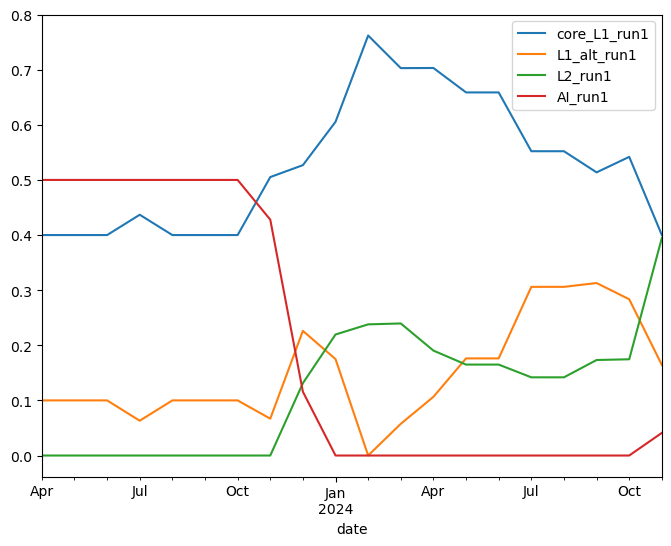

In [325]:
weights_df.plot(figsize=(8,6))

In [323]:
weights_df

core_L1_run1   L1_alt_run1       L2_run1       AI_run1
date                                                              
2023-04-30      0.400000  1.000000e-01  2.220446e-16  5.000000e-01
2023-05-31      0.400000  1.000000e-01  3.885781e-16  5.000000e-01
2023-06-30      0.400000  1.000000e-01  3.885781e-16  5.000000e-01
2023-07-31      0.436857  6.314296e-02  0.000000e+00  5.000000e-01
2023-08-31      0.400000  1.000000e-01  0.000000e+00  5.000000e-01
2023-09-30      0.400000  1.000000e-01  2.505320e-17  5.000000e-01
2023-10-31      0.400000  1.000000e-01  0.000000e+00  5.000000e-01
2023-11-30      0.505197  6.684754e-02  0.000000e+00  4.279553e-01
2023-12-31      0.526850  2.261692e-01  1.312901e-01  1.156911e-01
2024-01-31      0.605489  1.749074e-01  2.196036e-01  2.974780e-18
2024-02-29      0.762028  1.981379e-17  2.379717e-01  3.757356e-17
2024-03-31      0.702868  5.753428e-02  2.395974e-01  0.000000e+00
2024-04-30      0.703125  1.065075e-01  1.903673e-01  1.835256e-16
2024-05-31      0.658797  1.762137e-01  1.649894e-01  0.000000e+00
2024-06-30      0.658797  1.762138e-01  1.649891e-01  3.363206e-17
2024-07-31      0.552095  3.060284e-01  1.418762e-01  1.143981e-15
2024-08-31      0.552096  3.060280e-01  1.418763e-01  0.000000e+00
2024-09-30      0.513742  3.129561e-01  1.733017e-01  1.506526e-15
2024-10-31      0.541870  2.835086e-01  1.746214e-01  2.741371e-16
2024-11-30      0.400000  1.643260e-01  3.945978e-01  4.107623e-02

In [321]:
perf_df

train_ann_ret  train_ann_vol  train_sharpe  test_ann_ret  \
date                                                                   
2023-04-30       0.184561       0.105948      1.190600     -0.076207   
2023-05-31       0.176635       0.106085      1.125878      0.000000   
2023-06-30       0.176635       0.106085      1.125878      1.296572   
2023-07-31       0.266800       0.124976      1.563789      0.000000   
2023-08-31       0.258989       0.116928      1.610269      0.000000   
2023-09-30       0.258989       0.116928      1.610269      0.206975   
2023-10-31       0.279210       0.117422      1.739762      4.728255   
2023-11-30       0.503800       0.155289      2.390662      0.830761   
2023-12-31       0.599283       0.163816      2.650750     -0.155372   
2024-01-31       0.495785       0.166750      2.205064      4.187839   
2024-02-29       0.883391       0.185783      3.238350      0.905804   
2024-03-31       0.863087       0.186870      3.162720     -0.277039   
2024-04-30       0.779032       0.182869      2.975020      0.000000   
2024-05-31       0.763262       0.175716      3.038298      0.000000   
2024-06-30       0.763262       0.175716      3.038298      0.000000   
2024-07-31       0.608980       0.153228      2.862499      0.000000   
2024-08-31       0.608980       0.153228      2.862499      0.241938   
2024-09-30       0.625297       0.155033      2.896220     -0.266876   
2024-10-31       0.531518       0.156838      2.485220     12.658762   
2024-11-30       0.591204       0.157546      2.717325     -0.336717   

            test_ann_vol  test_sharpe  
date                                   
2023-04-30      0.016115    -7.938436  
2023-05-31      0.000000         -inf  
2023-06-30      0.215816     3.732504  
2023-07-31      0.000000         -inf  
2023-08-31      0.000000         -inf  
2023-09-30      0.039637     3.535364  
2023-10-31      0.328848     5.328623  
2023-11-30      0.176297     3.241407  
2023-12-31      0.061128    -3.530367  
2024-01-31      0.193405     8.371221  
2024-02-29      0.296216     2.156322  
2024-03-31      0.076692    -4.826950  
2024-04-30      0.000000         -inf  
2024-05-31      0.000000         -inf  
2024-06-30      0.000000         -inf  
2024-07-31      0.000000         -inf  
2024-08-31      0.139063     1.274490  
2024-09-30      0.056036    -6.381096  
2024-10-31      0.461309     5.792310  
2024-11-30      0.091863    -4.952856

In [299]:
df_sleeve_rets.head()

core_L1_run1   L1_run2  L1_alt_run1   L2_run1   AI_run1  \
date                                                                  
2022-04-01      0.000000  0.000000     0.000000  0.000000  0.000000   
2022-04-02     -0.005886 -0.002146     0.000000 -0.003039  0.000000   
2022-04-03     -0.003868  0.004092     0.000000 -0.017926 -0.001674   
2022-04-04      0.011847  0.004603    -0.005787 -0.006794 -0.002039   
2022-04-05      0.010064 -0.002329    -0.015382  0.000000 -0.009659   

            DeFi_run1  DeFi_run2  
date                              
2022-04-01   0.000000   0.000000  
2022-04-02  -0.004624  -0.005773  
2022-04-03   0.001870  -0.004063  
2022-04-04   0.005407   0.004913  
2022-04-05  -0.012087  -0.016136

In [293]:
sleeves.keys()

dict_keys(['core_L1_run1', 'L1_run2', 'L1_alt_run1', 'L2_run1', 'AI_run1', 'DeFi_run1', 'DeFi_run2'])

In [ ]:
crypto_portfolio_ticker_dict = {
    'core_L1_run1': ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    'L1_run2'     : ['DOT-USD','ATOM-USD','LTC-USD','ALGO-USD','XLM-USD'],
    'L1_alt_run1' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2_run1'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI_run1'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
    'DeFi_run1'   : ['UNI-USD','AAVE-USD','AMP-USD','COMP-USD','MKR-USD'],
    'DeFi_run2'   : ['SNX-USD','SUSHI-USD','CRV-USD','BAL-USD','1INCH-USD']
}

In [ ]:
## Core Portfolio
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
prod_ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']
df_final_prod_config = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=prod_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_prod_config = df_final_prod_config[df_final_prod_config.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config = perf.calculate_asset_level_returns(df_final_prod_config, end_date_test, ticker_list)

portfolio_perf_metrics_prod_config = calculate_risk_and_performance_metrics(df_final_prod_config, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                            strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config


## L1 Run 2
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
l1_ticker_list = ['DOT-USD','ATOM-USD','LTC-USD','ALGO-USD','XLM-USD']
df_final_l1_run_2 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=l1_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_l1_run_2 = df_final_l1_run_2[df_final_l1_run_2.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_l1_run_2 = perf.calculate_asset_level_returns(df_final_l1_run_2, end_date_test, l1_ticker_list)

portfolio_perf_metrics_l1_run_2 = calculate_risk_and_performance_metrics(df_final_l1_run_2, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                         strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_l1_run_2

## L1 Alt Run 1
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
l1_alt_ticker_list = ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD']
df_final_l1_alt_run_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=l1_alt_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_l1_alt_run_1 = df_final_l1_alt_run_1[df_final_l1_alt_run_1.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_l1_alt_run_1 = perf.calculate_asset_level_returns(df_final_l1_alt_run_1, end_date_test, l1_alt_ticker_list)

portfolio_perf_metrics_l1_alt_run_1 = calculate_risk_and_performance_metrics(df_final_l1_alt_run_1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                             strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_l1_alt_run_1


## L2 Run 1
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
l2_ticker_list = ['SKL-USD','IMX-USD','LRC-USD','STX-USD']
df_final_l2_run_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=l2_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_l2_run_1 = df_final_l2_run_1[df_final_l2_run_1.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_l2_run_1 = perf.calculate_asset_level_returns(df_final_l2_run_1, end_date_test, l2_ticker_list)

portfolio_perf_metrics_l2_run_1 = calculate_risk_and_performance_metrics(df_final_l2_run_1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                         strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_l2_run_1


## AI Run 1
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
ai_ticker_list = ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD']
df_final_ai_run_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=ai_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_ai_run_1 = df_final_ai_run_1[df_final_ai_run_1.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_ai_run_1 = perf.calculate_asset_level_returns(df_final_ai_run_1, end_date_test, ai_ticker_list)

portfolio_perf_metrics_ai_run_1 = calculate_risk_and_performance_metrics(df_final_ai_run_1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                         strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_ai_run_1


## Defi Run 1
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
defi_ticker_list = ['UNI-USD','AAVE-USD','AMP-USD','COMP-USD','MKR-USD']
df_final_defi_run_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=defi_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_defi_run_1 = df_final_defi_run_1[df_final_defi_run_1.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_defi_run_1 = perf.calculate_asset_level_returns(df_final_defi_run_1, end_date_test, defi_ticker_list)

portfolio_perf_metrics_defi_run_1 = calculate_risk_and_performance_metrics(df_final_defi_run_1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                            strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_defi_run_1

## Defi Run 2
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
defi_ticker_list_2 = ['SNX-USD','SUSHI-USD','CRV-USD','BAL-USD','1INCH-USD']
df_final_defi_run_2 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=defi_ticker_list_2, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_defi_run_2 = df_final_defi_run_2[df_final_defi_run_2.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_defi_run_2 = perf.calculate_asset_level_returns(df_final_defi_run_2, end_date_test, defi_ticker_list_2)

portfolio_perf_metrics_defi_run_2 = calculate_risk_and_performance_metrics(df_final_defi_run_2, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_defi_run_2

In [261]:
n_sleeves

4

In [211]:
sleeve_ret[live_sleeves]

core_L1_run1  L1_alt_run1   L2_run1   AI_run1
date                                                     
2022-04-01      0.000000     0.000000  0.000000  0.000000
2022-04-02     -0.005886     0.000000 -0.003039  0.000000
2022-04-03     -0.003868     0.000000 -0.017926 -0.001674
2022-04-04      0.011847    -0.005787 -0.006794 -0.002039
2022-04-05      0.010064    -0.015382  0.000000 -0.009659
2022-04-06     -0.015818    -0.010432  0.000000 -0.006969
2022-04-07     -0.018094     0.000000  0.000000  0.000000
2022-04-08      0.000000     0.000000  0.000000  0.000000
2022-04-09      0.000000     0.000000  0.000000  0.000000
2022-04-10      0.000000     0.000000  0.000000  0.000000
2022-04-11      0.000000     0.000000  0.000000  0.000000
2022-04-12      0.000000     0.000000  0.000000  0.000000
2022-04-13      0.000000     0.000000  0.000000  0.000000
2022-04-14      0.000000     0.000000  0.000000  0.000000
2022-04-15      0.000000     0.000000  0.000000  0.000000
2022-04-16      0.000000     0.000000  0.000000  0.000000
2022-04-17      0.000000     0.000000  0.000000  0.000000
2022-04-18      0.000000     0.000000  0.000000  0.000000
2022-04-19      0.000000     0.000000  0.000000  0.000000
2022-04-20      0.000000     0.000000  0.000000  0.000000
2022-04-21      0.000000     0.000000  0.000000  0.000000
2022-04-22      0.000000     0.000000  0.000000  0.000000
2022-04-23      0.000000     0.000000  0.000000  0.000000
2022-04-24      0.000000     0.000000  0.000000  0.000000
2022-04-25      0.000000     0.000000  0.000000  0.000000
2022-04-26      0.000000     0.000000  0.000000  0.000000
2022-04-27      0.000000     0.000000  0.000000  0.000000
2022-04-28      0.000000     0.000000  0.000000  0.000000
2022-04-29      0.000000     0.000000  0.000000  0.000000
2022-04-30      0.000000     0.000000  0.000000  0.000000
2022-05-01      0.000000     0.000000  0.000000  0.000000
2022-05-02      0.000000     0.000000  0.000000  0.000000
2022-05-03      0.000000     0.000000  0.000000  0.000000
2022-05-04      0.000000     0.000000  0.000000  0.000000
2022-05-05      0.000000     0.000000  0.000000  0.000000
2022-05-06      0.000000     0.000000  0.000000  0.000000
2022-05-07      0.000000     0.000000  0.000000  0.000000
2022-05-08      0.000000     0.000000  0.000000  0.000000
2022-05-09      0.000000     0.000000  0.000000  0.000000
2022-05-10      0.000000     0.000000  0.000000  0.000000
2022-05-11      0.000000     0.000000  0.000000  0.000000
2022-05-12      0.000000     0.000000  0.000000  0.000000
2022-05-13      0.000000     0.000000  0.000000  0.000000
2022-05-14      0.000000     0.000000  0.000000  0.000000
2022-05-15      0.000000     0.000000  0.000000  0.000000
2022-05-16      0.000000     0.000000  0.000000  0.000000
2022-05-17      0.000000     0.000000  0.000000  0.000000
2022-05-18      0.000000     0.000000  0.000000  0.000000
2022-05-19      0.000000     0.000000  0.000000  0.000000
2022-05-20      0.000000     0.000000  0.000000  0.000000
2022-05-21      0.000000     0.000000  0.000000  0.000000
2022-05-22      0.000000     0.000000  0.000000  0.000000
2022-05-23      0.000000     0.000000  0.000000  0.000000
2022-05-24      0.000000     0.000000  0.000000  0.000000
2022-05-25      0.000000     0.000000  0.000000  0.000000
2022-05-26      0.000000     0.000000  0.000000  0.000000
2022-05-27      0.000000     0.000000  0.000000  0.000000
2022-05-28      0.000000     0.000000  0.000000  0.000000
2022-05-29      0.000000     0.000000  0.000000  0.000000
2022-05-30      0.000000     0.000000  0.000000  0.000000
2022-05-31      0.000000     0.000000  0.000000  0.000000
2022-06-01      0.000000     0.000000  0.000000  0.000000
2022-06-02      0.000000     0.000000  0.000000  0.000000
2022-06-03      0.000000     0.000000  0.000000  0.000000
2022-06-04      0.000000     0.000000  0.000000  0.000000
2022-06-05      0.000000     0.000000  0.000000  0.000000
2022-06-06      0.000000     0.000000  0.000000  0.000000
2022-06-07

In [213]:
sleeve_weights_list

[1.0, 0.0, 0.0, 0.0]

In [209]:
(sleeve_ret[live_sleeves] @ sleeve_weights_list)

date
2022-04-01    0.000000
2022-04-02   -0.005886
2022-04-03   -0.003868
2022-04-04    0.011847
2022-04-05    0.010064
2022-04-06   -0.015818
2022-04-07   -0.018094
2022-04-08    0.000000
2022-04-09    0.000000
2022-04-10    0.000000
2022-04-11    0.000000
2022-04-12    0.000000
2022-04-13    0.000000
2022-04-14    0.000000
2022-04-15    0.000000
2022-04-16    0.000000
2022-04-17    0.000000
2022-04-18    0.000000
2022-04-19    0.000000
2022-04-20    0.000000
2022-04-21    0.000000
2022-04-22    0.000000
2022-04-23    0.000000
2022-04-24    0.000000
2022-04-25    0.000000
2022-04-26    0.000000
2022-04-27    0.000000
2022-04-28    0.000000
2022-04-29    0.000000
2022-04-30    0.000000
2022-05-01    0.000000
2022-05-02    0.000000
2022-05-03    0.000000
2022-05-04    0.000000
2022-05-05    0.000000
2022-05-06    0.000000
2022-05-07    0.000000
2022-05-08    0.000000
2022-05-09    0.000000
2022-05-10    0.000000
2022-05-11    0.000000
2022-05-12    0.000000
2022-05-13    0.000000
2022-0

In [165]:
live_sleeve_ret[live_sleeves]

core_L1_run1  L1_alt_run1   L2_run1   AI_run1
date                                                     
2022-04-01      0.000000     0.000000  0.000000  0.000000
2022-04-02     -0.005886     0.000000 -0.003039  0.000000
2022-04-03     -0.003868     0.000000 -0.017926 -0.001674
2022-04-04      0.011847    -0.005787 -0.006794 -0.002039
2022-04-05      0.010064    -0.015382  0.000000 -0.009659
2022-04-06     -0.015818    -0.010432  0.000000 -0.006969
2022-04-07     -0.018094     0.000000  0.000000  0.000000
2022-04-08      0.000000     0.000000  0.000000  0.000000
2022-04-09      0.000000     0.000000  0.000000  0.000000
2022-04-10      0.000000     0.000000  0.000000  0.000000
2022-04-11      0.000000     0.000000  0.000000  0.000000
2022-04-12      0.000000     0.000000  0.000000  0.000000
2022-04-13      0.000000     0.000000  0.000000  0.000000
2022-04-14      0.000000     0.000000  0.000000  0.000000
2022-04-15      0.000000     0.000000  0.000000  0.000000
2022-04-16      0.000000     0.000000  0.000000  0.000000
2022-04-17      0.000000     0.000000  0.000000  0.000000
2022-04-18      0.000000     0.000000  0.000000  0.000000
2022-04-19      0.000000     0.000000  0.000000  0.000000
2022-04-20      0.000000     0.000000  0.000000  0.000000
2022-04-21      0.000000     0.000000  0.000000  0.000000
2022-04-22      0.000000     0.000000  0.000000  0.000000
2022-04-23      0.000000     0.000000  0.000000  0.000000
2022-04-24      0.000000     0.000000  0.000000  0.000000
2022-04-25      0.000000     0.000000  0.000000  0.000000
2022-04-26      0.000000     0.000000  0.000000  0.000000
2022-04-27      0.000000     0.000000  0.000000  0.000000
2022-04-28      0.000000     0.000000  0.000000  0.000000
2022-04-29      0.000000     0.000000  0.000000  0.000000
2022-04-30      0.000000     0.000000  0.000000  0.000000
2022-05-01      0.000000     0.000000  0.000000  0.000000
2022-05-02      0.000000     0.000000  0.000000  0.000000
2022-05-03      0.000000     0.000000  0.000000  0.000000
2022-05-04      0.000000     0.000000  0.000000  0.000000
2022-05-05      0.000000     0.000000  0.000000  0.000000
2022-05-06      0.000000     0.000000  0.000000  0.000000
2022-05-07      0.000000     0.000000  0.000000  0.000000
2022-05-08      0.000000     0.000000  0.000000  0.000000
2022-05-09      0.000000     0.000000  0.000000  0.000000
2022-05-10      0.000000     0.000000  0.000000  0.000000
2022-05-11      0.000000     0.000000  0.000000  0.000000
2022-05-12      0.000000     0.000000  0.000000  0.000000
2022-05-13      0.000000     0.000000  0.000000  0.000000
2022-05-14      0.000000     0.000000  0.000000  0.000000
2022-05-15      0.000000     0.000000  0.000000  0.000000
2022-05-16      0.000000     0.000000  0.000000  0.000000
2022-05-17      0.000000     0.000000  0.000000  0.000000
2022-05-18      0.000000     0.000000  0.000000  0.000000
2022-05-19      0.000000     0.000000  0.000000  0.000000
2022-05-20      0.000000     0.000000  0.000000  0.000000
2022-05-21      0.000000     0.000000  0.000000  0.000000
2022-05-22      0.000000     0.000000  0.000000  0.000000
2022-05-23      0.000000     0.000000  0.000000  0.000000
2022-05-24      0.000000     0.000000  0.000000  0.000000
2022-05-25      0.000000     0.000000  0.000000  0.000000
2022-05-26      0.000000     0.000000  0.000000  0.000000
2022-05-27      0.000000     0.000000  0.000000  0.000000
2022-05-28      0.000000     0.000000  0.000000  0.000000
2022-05-29      0.000000     0.000000  0.000000  0.000000
2022-05-30      0.000000     0.000000  0.000000  0.000000
2022-05-31      0.000000     0.000000  0.000000  0.000000
2022-06-01      0.000000     0.000000  0.000000  0.000000
2022-06-02      0.000000     0.000000  0.000000  0.000000
2022-06-03      0.000000     0.000000  0.000000  0.000000
2022-06-04      0.000000     0.000000  0.000000  0.000000
2022-06-05      0.000000     0.000000  0.000000  0.000000
2022-06-06      0.000000     0.000000  0.000000  0.000000
2022-06-07

In [167]:
np.asarray(sleeve_weights, dtype=float)

TypeError: float() argument must be a string or a real number, not 'dict'

In [159]:
sleeve_weights

{'core_L1_run1': 1.0, 'L1_alt_run1': 0.0, 'L2_run1': 0.0, 'AI_run1': 0.0}

In [161]:
(live_sleeve_ret[live_sleeves] @ sleeve_weights)#.rename("portfolio_daily_pct_returns")

KeyError: "None of [Index([('core_L1_run1', 'L1_alt_run1', 'L2_run1', 'AI_run1')], dtype='object')] are in the [columns]"

In [137]:
live_sleeve_ret.head()

core_L1_run1  L1_alt_run1   L2_run1   AI_run1
date                                                     
2022-04-01      0.000000     0.000000  0.000000  0.000000
2022-04-02     -0.005886     0.000000 -0.003039  0.000000
2022-04-03     -0.003868     0.000000 -0.017926 -0.001674
2022-04-04      0.011847    -0.005787 -0.006794 -0.002039
2022-04-05      0.010064    -0.015382  0.000000 -0.009659

In [215]:
import numpy as np
import pandas as pd
import scipy.optimize as sco

# import strategy_performance as perf  # <- your module

ANN_DAYS = 365

# # Choose sleeves to include in optimization
# keep_cols = ['core_L1_run1', 'L1_alt_run1', 'L2_run1', 'AI_run1']  # add "defi1" if you want

# # df_sleeve_rets has one column per sleeve with daily % returns
# rets = live_sleeve_ret[keep_cols].dropna()

# def portfolio_stats(w, ann_days=ANN_DAYS, annual_rf=0.05):
#     """
#     Return (annualized_return, annualized_std_dev, annualized_sharpe_ratio)
#     computed using *the same logic* as summarize_strategy /
#     calculate_risk_and_performance_metrics.
#     """
#     w = np.array(w)

#     # Daily portfolio return series
#     port_daily_ret = (rets[keep_cols] @ w).rename("portfolio_daily_pct_returns")

#     # Dummy trade-count series: Sharpe/stddev don't use it when
#     # include_transaction_costs_and_fees=False, so 1 is fine.
#     tmp = pd.DataFrame(
#         {
#             "portfolio_daily_pct_returns": port_daily_ret,
#             "count_of_positions": 1,
#         }
#     )

#     perf_metrics = perf.calculate_risk_and_performance_metrics(
#         tmp,
#         strategy_daily_return_col="portfolio_daily_pct_returns",
#         strategy_trade_count_col="count_of_positions",
#         annual_rf=annual_rf,
#         annual_trading_days=ann_days,
#         include_transaction_costs_and_fees=False,  # match your summarize_strategy usage
#         transaction_cost_est=0.0,
#         passive_trade_rate=0.0,
#     )

#     return (
#         perf_metrics["annualized_return"],
#         perf_metrics["annualized_std_dev"],
#         perf_metrics["annualized_sharpe_ratio"],
#     )

# def neg_sharpe(w):
#     return -portfolio_stats(w)[2]  # index 2 = annualized_sharpe_ratio

# n = len(keep_cols)

# Constraints
cons = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1.0},   # sum w = 1
    {"type": "ineq", "fun": lambda w: w[0] - 0.40},     # core >= 40% (index 0 = "core")
]

# Bounds: no negative weights; cap any single sleeve at, say, 50 %
bounds = [(0.0, 0.5)] * n

w0 = np.ones(n) / n

res = sco.minimize(neg_sharpe, w0, bounds=bounds, constraints=cons)

w_opt = pd.Series(res.x, index=keep_cols)

ann_ret, ann_vol, ann_sharpe = portfolio_stats(w_opt.values)

print("Optimal weights:")
print(w_opt)
print("Portfolio stats (ann_ret, ann_vol, ann_sharpe):", ann_ret, ann_vol, ann_sharpe)


TypeError: neg_sharpe() missing 2 required positional arguments: 'sleeve_returns' and 'live_sleeves'

In [175]:
w0

array([0.25, 0.25, 0.25, 0.25])

In [208]:
weights = {
    "core_L1_run1": 0.7,
    "L1_run2":      0.15,
    "DeFi_run1":    0.15,
}

combined_ret, combined_count = combine_sleeves(sleeve_ret, sleeve_count, weights)
combined_stats = summarize_strategy(combined_ret, combined_count)
combined_stats

{'annualized_return': 0.30945027645284573,
 'annualized_std_dev': 0.2968274811229828,
 'annualized_sharpe_ratio': 1.5170343389147283,
 'max_drawdown': -0.09927038423046336}

In [210]:
weights = {
    "core_L1_run1": 0.7,
    "L1_run2":      0.15,
    "L1_run3":      0.15,
}

combined_ret, combined_count = combine_sleeves(sleeve_ret, sleeve_count, weights)
combined_stats = summarize_strategy(combined_ret, combined_count)
combined_stats

{'annualized_return': 0.30893629579311677,
 'annualized_std_dev': 0.3178817806251011,
 'annualized_sharpe_ratio': 1.4790573805053062,
 'max_drawdown': -0.1000292210046987}

In [212]:
weights = {
    "core_L1_run1": 0.7,
    "DeFi_run1":    0.15,
    "DeFi_run2":    0.15,
}

combined_ret, combined_count = combine_sleeves(sleeve_ret, sleeve_count, weights)
combined_stats = summarize_strategy(combined_ret, combined_count)
combined_stats

{'annualized_return': 0.3655923800672096,
 'annualized_std_dev': 0.36728671447509376,
 'annualized_sharpe_ratio': 1.5936514873049958,
 'max_drawdown': -0.11022123751770664}

In [214]:
weights = {
    "core_L1_run1": 0.8,
    "DeFi_run1":    0.1,
    "DeFi_run2":    0.1,
}

combined_ret, combined_count = combine_sleeves(sleeve_ret, sleeve_count, weights)
combined_stats = summarize_strategy(combined_ret, combined_count)
combined_stats

{'annualized_return': 0.3555961728278376,
 'annualized_std_dev': 0.350149222657439,
 'annualized_sharpe_ratio': 1.593093534095233,
 'max_drawdown': -0.11667979843647919}

In [ ]:
## Core L1 Portfolio Performance
{'annualized_return': 0.3317590416631553,
 'annualized_sharpe_ratio': 1.4134421786840479,
 'calmar_ratio': 2.560309328537423,
 'annualized_std_dev': 0.4247262948243901,
 'max_drawdown': -0.12957771858475892,
 'max_drawdown_duration': Timedelta('283 days 00:00:00'),
 'hit_rate': 0.13717693836978131,
 't_statistic': 2.798163113836065,
 'p_value': 0.005237657951494762,
 'trade_count': 139.0}

### Coin Level Stats

In [216]:
core_name = "core_L1_run1"
core_df = sleeves[core_name]
core_ret = core_df["portfolio_daily_pct_returns"]  # core portfolio return series

def compute_coin_level_stats(df_run, ticker_list, sleeve_name,
                             core_ret, ret_suffix=ASSET_RET_SUFFIX,
                             ann_days=ANN_DAYS, annual_rf=0.05):
    """
    df_run: backtest DF for a sleeve
    ticker_list: tickers in this run
    sleeve_name: name for this sleeve (for tracking)
    core_ret: Series of core portfolio daily returns
    """
    daily_rf = (1 + annual_rf) ** (1/ann_days) - 1
    rows = []
    for t in ticker_list:
        col = f"{t}{ret_suffix}"
        if col not in df_run.columns:
            continue
        r = df_run[col].dropna()
        if r.empty:
            continue

        mu = (r - daily_rf).mean()
        sig = (r - daily_rf).std()
        ann_ret = mu * ann_days
        ann_vol = sig * np.sqrt(ann_days)
        sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
        hit_rate = (r > 0).mean()
        trade_count = (r != 0).sum()  # rough; you have more detailed trade info if needed

        aligned = pd.concat([r, core_ret], axis=1, join="inner").dropna()
        corr_to_core = aligned.iloc[:, 0].corr(aligned.iloc[:, 1]) if len(aligned) > 1 else np.nan

        rows.append({
            "ticker": t,
            "sleeve": sleeve_name,
            "ann_return": ann_ret,
            "ann_vol": ann_vol,
            "sharpe": sharpe,
            "hit_rate": hit_rate,
            "trade_count": trade_count,
            "corr_to_core": corr_to_core,
        })

    return pd.DataFrame(rows)


In [218]:
core_ret

date
2022-04-01    0.000000
2022-04-02   -0.005886
2022-04-03   -0.003868
2022-04-04    0.011847
2022-04-05    0.010064
2022-04-06   -0.015818
2022-04-07   -0.018094
2022-04-08    0.000000
2022-04-09    0.000000
2022-04-10    0.000000
2022-04-11    0.000000
2022-04-12    0.000000
2022-04-13    0.000000
2022-04-14    0.000000
2022-04-15    0.000000
2022-04-16    0.000000
2022-04-17    0.000000
2022-04-18    0.000000
2022-04-19    0.000000
2022-04-20    0.000000
2022-04-21    0.000000
2022-04-22    0.000000
2022-04-23    0.000000
2022-04-24    0.000000
2022-04-25    0.000000
2022-04-26    0.000000
2022-04-27    0.000000
2022-04-28    0.000000
2022-04-29    0.000000
2022-04-30    0.000000
2022-05-01    0.000000
2022-05-02    0.000000
2022-05-03    0.000000
2022-05-04    0.000000
2022-05-05    0.000000
2022-05-06    0.000000
2022-05-07    0.000000
2022-05-08    0.000000
2022-05-09    0.000000
2022-05-10    0.000000
2022-05-11    0.000000
2022-05-12    0.000000
2022-05-13    0.000000
2022-0

In [226]:
coin_stats_list = []

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["core_L1_run1"],
        ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
        sleeve_name="core_L1_run1",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["L1_run2"],
        ticker_list=['DOGE-USD','LTC-USD','DOT-USD','ALGO-USD','XLM-USD'],
        sleeve_name="L1_run2",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["L1_run3"],
        ticker_list=['ATOM-USD','ICP-USD','XTZ-USD','FIL-USD','CRO-USD'],
        sleeve_name="L1_run3",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["L2_run1"],
        ticker_list=['SKL-USD','LRC-USD','IMX-USD','STX-USD'],
        sleeve_name="L2_run1",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["DeFi_run1"],
        ticker_list=['SHIB-USD','LINK-USD','UNI-USD','FET-USD','AAVE-USD'],
        sleeve_name="DeFi_run1",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["DeFi_run2"],
        ticker_list=['MANA-USD','OXT-USD','KRL-USD','AMP-USD','REQ-USD'],
        sleeve_name="DeFi_run2",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["DeFi_run3"],
        ticker_list=['GRT-USD','COMP-USD','MKR-USD','SNX-USD','SUSHI-USD'],
        sleeve_name="DeFi_run3",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["DeFi_run4"],
        ticker_list=['CRV-USD','BAL-USD','1INCH-USD','DIA-USD'],
        sleeve_name="DeFi_run4",
        core_ret=core_ret,
    )
)

coin_stats = pd.concat(coin_stats_list, ignore_index=True)


In [ ]:
defi_ticker_list = ['SHIB-USD','LINK-USD','UNI-USD','FET-USD','AAVE-USD']
defi_ticker_list_2 = ['MANA-USD','OXT-USD','KRL-USD','AMP-USD','REQ-USD']
defi_ticker_list_3 = ['GRT-USD','COMP-USD','MKR-USD','SNX-USD','SUSHI-USD']
defi_ticker_list_4 = ['CRV-USD','BAL-USD','1INCH-USD','DIA-USD']

In [228]:
coin_stats_list

[     ticker        sleeve  ann_return   ann_vol    sharpe  hit_rate  \
 0   BTC-USD  core_L1_run1    0.042016  0.089041  0.471876  0.090457   
 1   ETH-USD  core_L1_run1    0.022071  0.076451  0.288696  0.062624   
 2   SOL-USD  core_L1_run1    0.008239  0.071703  0.114907  0.016899   
 3   ADA-USD  core_L1_run1   -0.034885  0.063295 -0.551147  0.045726   
 4  AVAX-USD  core_L1_run1    0.042767  0.085679  0.499159  0.020875   
 
    trade_count  corr_to_core  
 0          183      0.097973  
 1          118     -0.022439  
 2           31     -0.028608  
 3           84      0.015484  
 4           45      0.228602  ,
      ticker   sleeve  ann_return   ann_vol    sharpe  hit_rate  trade_count  \
 0  DOGE-USD  L1_run2    0.043131  0.109055  0.395501  0.034791           64   
 1   LTC-USD  L1_run2   -0.057027  0.078460 -0.726829  0.029821           66   
 2   DOT-USD  L1_run2    0.033476  0.108719  0.307914  0.027833           56   
 3  ALGO-USD  L1_run2   -0.024889  0.044459 -0.559831

In [230]:
coin_stats

ticker        sleeve  ann_return   ann_vol    sharpe  hit_rate  \
0     BTC-USD  core_L1_run1    0.042016  0.089041  0.471876  0.090457   
1     ETH-USD  core_L1_run1    0.022071  0.076451  0.288696  0.062624   
2     SOL-USD  core_L1_run1    0.008239  0.071703  0.114907  0.016899   
3     ADA-USD  core_L1_run1   -0.034885  0.063295 -0.551147  0.045726   
4    AVAX-USD  core_L1_run1    0.042767  0.085679  0.499159  0.020875   
5    DOGE-USD       L1_run2    0.043131  0.109055  0.395501  0.034791   
6     LTC-USD       L1_run2   -0.057027  0.078460 -0.726829  0.029821   
7     DOT-USD       L1_run2    0.033476  0.108719  0.307914  0.027833   
8    ALGO-USD       L1_run2   -0.024889  0.044459 -0.559831  0.022863   
9     XLM-USD       L1_run2   -0.060710  0.016261 -3.733544  0.011928   
10   ATOM-USD       L1_run3   -0.050115  0.068228 -0.734522  0.019881   
11    ICP-USD       L1_run3    0.103505  0.096205  1.075885  0.049702   
12    XTZ-USD       L1_run3    0.011581  0.077401  0.149630  0.040755   
13    FIL-USD       L1_run3   -0.056740  0.015553 -3.648271  0.002982   
14    CRO-USD       L1_run3    0.053450  0.192635  0.277467  0.022863   
15    SKL-USD       L2_run1   -0.027705  0.072636 -0.381430  0.043738   
16    LRC-USD       L2_run1    0.025141  0.092369  0.272177  0.027833   
17    IMX-USD       L2_run1    0.046925  0.075094  0.624887  0.048708   
18    STX-USD       L2_run1   -0.033837  0.070806 -0.477876  0.017893   
19   SHIB-USD     DeFi_run1    0.059026  0.130602  0.451952  0.026839   
20   LINK-USD     DeFi_run1   -0.005373  0.085517 -0.062832  0.019881   
21    UNI-USD     DeFi_run1   -0.038753  0.061279 -0.632392  0.029821   
22    FET-USD     DeFi_run1    0.093090  0.144604  0.643757  0.034791   
23   AAVE-USD     DeFi_run1   -0.052688  0.054985 -0.958241  0.022863   
24   MANA-USD     DeFi_run2    0.010624  0.104335  0.101828  0.022863   
25    OXT-USD     DeFi_run2   -0.071340  0.077658 -0.918651  0.018887   
26    KRL-USD     DeFi_run2    0.269065  0.568665  0.473152  0.008946   
27    AMP-USD     DeFi_run2    0.035151  0.124404  0.282556  0.007952   
28    REQ-USD     DeFi_run2   -0.047717  0.019525 -2.443860  0.002982   
29    GRT-USD     DeFi_run3    0.010733  0.076040  0.141153  0.028827   
30   COMP-USD     DeFi_run3   -0.063475  0.036748 -1.727302  0.020875   
31    MKR-USD     DeFi_run3   -0.004140  0.131603 -0.031458  0.032803   
32    SNX-USD     DeFi_run3   -0.065947  0.073307 -0.899593  0.024851   
33  SUSHI-USD     DeFi_run3    0.072349  0.112572  0.642689  0.029821   
34    CRV-USD     DeFi_run4   -0.089249  0.049232 -1.812829  0.017893   
35    BAL-USD     DeFi_run4   -0.066639  0.054167 -1.230257  0.022863   
36  1INCH-USD     DeFi_run4   -0.048348  0.090607 -0.533601  0.040755   
37    DIA-USD     DeFi_run4   -0.003153  0.093819 -0.033605  0.024851   

    trade_count  corr_to_core  
0           183      0.097973  
1           118     -0.022439  
2            31     -0.028608  
3            84      0.015484  
4            45      0.228602  
5            64      0.074638  
6            66     -0.031467  
7            56     -0.042381  
8            48      0.014481  
9            21     -0.013959  
10           42     -0.002762  
11           87      0.007957  
12           71      0.064994  
13           14      0.041141  
14           40      0.091755  
15           80     -0.051409  
16           53     -0.047460  
17          103     -0.001294  
18           41     -0.033464  
19           53     -0.023275  
20           41     -0.067611  
21           57     -0.025559  
22           73      0.005187  
23           48      0.047438  
24           47     -0.014144  
25           37     -0.049509  
26           19     -0.026737  
27           17      0.053850  
28            8     -0.018667  
29           61      0.060205  
30           50     -0.042929  
31           78     -0.039467  
32           50     -0.097987  
33           57     -0.038877  
34           39     -0.004235  
35     

### Picking Coins to Trade Alongside Core Portfolio of L1 Coins

In [233]:
core_tickers = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']

coin_stats["is_core"] = coin_stats["ticker"].isin(core_tickers)

LAMBDA = 0.5  # penalty for correlation to core
coin_stats["score"] = coin_stats["sharpe"] - LAMBDA * coin_stats["corr_to_core"]

# Non-core candidates with basic quality filters
alt_candidates = coin_stats[
    (~coin_stats["is_core"]) &
    (coin_stats["sharpe"] > 0) &
    (coin_stats["trade_count"] >= 30)
].copy()

alt_candidates = alt_candidates.sort_values("score", ascending=False)

K = 8  # eg: start with top 8 alts
alt_universe_static = alt_candidates["ticker"].unique().tolist()[:K]

print("Static alt universe:", alt_universe_static)


Static alt universe: ['ICP-USD', 'SUSHI-USD', 'FET-USD', 'IMX-USD', 'SHIB-USD', 'DOGE-USD', 'DOT-USD', 'LRC-USD']


In [235]:
core_tickers + alt_universe_static

['BTC-USD',
 'ETH-USD',
 'SOL-USD',
 'ADA-USD',
 'AVAX-USD',
 'ICP-USD',
 'SUSHI-USD',
 'FET-USD',
 'IMX-USD',
 'SHIB-USD',
 'DOGE-USD',
 'DOT-USD',
 'LRC-USD']

In [237]:
coin_stats

ticker        sleeve  ann_return   ann_vol    sharpe  hit_rate  \
0     BTC-USD  core_L1_run1    0.042016  0.089041  0.471876  0.090457   
1     ETH-USD  core_L1_run1    0.022071  0.076451  0.288696  0.062624   
2     SOL-USD  core_L1_run1    0.008239  0.071703  0.114907  0.016899   
3     ADA-USD  core_L1_run1   -0.034885  0.063295 -0.551147  0.045726   
4    AVAX-USD  core_L1_run1    0.042767  0.085679  0.499159  0.020875   
5    DOGE-USD       L1_run2    0.043131  0.109055  0.395501  0.034791   
6     LTC-USD       L1_run2   -0.057027  0.078460 -0.726829  0.029821   
7     DOT-USD       L1_run2    0.033476  0.108719  0.307914  0.027833   
8    ALGO-USD       L1_run2   -0.024889  0.044459 -0.559831  0.022863   
9     XLM-USD       L1_run2   -0.060710  0.016261 -3.733544  0.011928   
10   ATOM-USD       L1_run3   -0.050115  0.068228 -0.734522  0.019881   
11    ICP-USD       L1_run3    0.103505  0.096205  1.075885  0.049702   
12    XTZ-USD       L1_run3    0.011581  0.077401  0.149630  0.040755   
13    FIL-USD       L1_run3   -0.056740  0.015553 -3.648271  0.002982   
14    CRO-USD       L1_run3    0.053450  0.192635  0.277467  0.022863   
15    SKL-USD       L2_run1   -0.027705  0.072636 -0.381430  0.043738   
16    LRC-USD       L2_run1    0.025141  0.092369  0.272177  0.027833   
17    IMX-USD       L2_run1    0.046925  0.075094  0.624887  0.048708   
18    STX-USD       L2_run1   -0.033837  0.070806 -0.477876  0.017893   
19   SHIB-USD     DeFi_run1    0.059026  0.130602  0.451952  0.026839   
20   LINK-USD     DeFi_run1   -0.005373  0.085517 -0.062832  0.019881   
21    UNI-USD     DeFi_run1   -0.038753  0.061279 -0.632392  0.029821   
22    FET-USD     DeFi_run1    0.093090  0.144604  0.643757  0.034791   
23   AAVE-USD     DeFi_run1   -0.052688  0.054985 -0.958241  0.022863   
24   MANA-USD     DeFi_run2    0.010624  0.104335  0.101828  0.022863   
25    OXT-USD     DeFi_run2   -0.071340  0.077658 -0.918651  0.018887   
26    KRL-USD     DeFi_run2    0.269065  0.568665  0.473152  0.008946   
27    AMP-USD     DeFi_run2    0.035151  0.124404  0.282556  0.007952   
28    REQ-USD     DeFi_run2   -0.047717  0.019525 -2.443860  0.002982   
29    GRT-USD     DeFi_run3    0.010733  0.076040  0.141153  0.028827   
30   COMP-USD     DeFi_run3   -0.063475  0.036748 -1.727302  0.020875   
31    MKR-USD     DeFi_run3   -0.004140  0.131603 -0.031458  0.032803   
32    SNX-USD     DeFi_run3   -0.065947  0.073307 -0.899593  0.024851   
33  SUSHI-USD     DeFi_run3    0.072349  0.112572  0.642689  0.029821   
34    CRV-USD     DeFi_run4   -0.089249  0.049232 -1.812829  0.017893   
35    BAL-USD     DeFi_run4   -0.066639  0.054167 -1.230257  0.022863   
36  1INCH-USD     DeFi_run4   -0.048348  0.090607 -0.533601  0.040755   
37    DIA-USD     DeFi_run4   -0.003153  0.093819 -0.033605  0.024851   

    trade_count  corr_to_core  is_core     score  
0           183      0.097973     True  0.422889  
1           118     -0.022439     True  0.299916  
2            31     -0.028608     True  0.129211  
3            84      0.015484     True -0.558889  
4            45      0.228602     True  0.384858  
5            64      0.074638    False  0.358181  
6            66     -0.031467    False -0.711095  
7            56     -0.042381    False  0.329104  
8            48      0.014481    False -0.567071  
9            21     -0.013959    False -3.726565  
10           42     -0.002762    False -0.733141  
11           87      0.007957    False  1.071907  
12           71      0.064994    False  0.117134  
13           14      0.041141    False -3.668842  
14           40      0.091755    False  0.231590  
15           80     -0.051409    False -0.355725  
16           53     -0.047460    False  0.295907  
17          103     -0.001294    False  0.625535  
18           41     -0.033464    False -0.461144  
19           53     -0.023275    False  0.463590  
20           41     -0.067611    False -0.029027  
21           57     -0.025559    Fals

In [239]:
alt_candidates

ticker     sleeve  ann_return   ann_vol    sharpe  hit_rate  \
11    ICP-USD    L1_run3    0.103505  0.096205  1.075885  0.049702   
33  SUSHI-USD  DeFi_run3    0.072349  0.112572  0.642689  0.029821   
22    FET-USD  DeFi_run1    0.093090  0.144604  0.643757  0.034791   
17    IMX-USD    L2_run1    0.046925  0.075094  0.624887  0.048708   
19   SHIB-USD  DeFi_run1    0.059026  0.130602  0.451952  0.026839   
5    DOGE-USD    L1_run2    0.043131  0.109055  0.395501  0.034791   
7     DOT-USD    L1_run2    0.033476  0.108719  0.307914  0.027833   
16    LRC-USD    L2_run1    0.025141  0.092369  0.272177  0.027833   
14    CRO-USD    L1_run3    0.053450  0.192635  0.277467  0.022863   
12    XTZ-USD    L1_run3    0.011581  0.077401  0.149630  0.040755   
29    GRT-USD  DeFi_run3    0.010733  0.076040  0.141153  0.028827   
24   MANA-USD  DeFi_run2    0.010624  0.104335  0.101828  0.022863   

    trade_count  corr_to_core  is_core     score  
11           87      0.007957    False  1.071907  
33           57     -0.038877    False  0.662128  
22           73      0.005187    False  0.641164  
17          103     -0.001294    False  0.625535  
19           53     -0.023275    False  0.463590  
5            64      0.074638    False  0.358181  
7            56     -0.042381    False  0.329104  
16           53     -0.047460    False  0.295907  
14           40      0.091755    False  0.231590  
12           71      0.064994    False  0.117134  
29           61      0.060205    False  0.111050  
24           47     -0.014144    False  0.108900

In [241]:
sleeve_ret.head()

core_L1_run1  L1_run2   L1_run3  L1_large   L2_run1  DeFi_run1  \
date                                                                         
2022-04-01      0.000000      0.0  0.000000  0.000000  0.000000   0.000000   
2022-04-02     -0.005886      0.0  0.000000  0.000000 -0.003039  -0.005616   
2022-04-03     -0.003868      0.0  0.000000  0.000000 -0.017926   0.002273   
2022-04-04      0.011847      0.0 -0.005787 -0.002632 -0.006794   0.008315   
2022-04-05      0.010064      0.0 -0.015382 -0.006973  0.000000  -0.011246   

            DeFi_run2  DeFi_run3  DeFi_run4  
date                                         
2022-04-01        0.0   0.000000   0.000000  
2022-04-02        0.0  -0.004738  -0.005995  
2022-04-03        0.0   0.004181  -0.006820  
2022-04-04        0.0   0.018773   0.015622  
2022-04-05        0.0  -0.011704  -0.020282

In [245]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
# defi_ticker_list_4 = ['CRV-USD','BAL-USD','1INCH-USD','DIA-USD']
expanded_universe_list = core_tickers + alt_universe_static
df_final_prod_config_backtested_expanded_alt_universe = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=expanded_universe_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_prod_config_backtested_expanded_alt_universe = df_final_prod_config_backtested_expanded_alt_universe[df_final_prod_config_backtested_expanded_alt_universe.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config_backtested_expanded_alt_universe = perf.calculate_asset_level_returns(df_final_prod_config_backtested_expanded_alt_universe, end_date_test, expanded_universe_list)

portfolio_perf_metrics_expanded_alt_universe = calculate_risk_and_performance_metrics(df_final_prod_config_backtested_expanded_alt_universe, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                      strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_expanded_alt_universe

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
SUSHI-USD
FET-USD
IMX-USD
SHIB-USD
DOGE-USD
DOT-USD
LRC-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.3262102505850011,
 'annualized_sharpe_ratio': 1.3759989042658405,
 'calmar_ratio': 3.0331489535281735,
 'annualized_std_dev': 0.42231170882134317,
 'max_drawdown': -0.10754837813209,
 'max_drawdown_duration': Timedelta('287 days 00:00:00'),
 'hit_rate': 0.12823061630218688,
 't_statistic': 2.7308948821050745,
 'p_value': 0.0064268133733742525,
 'trade_count': 174.0}

<Axes: xlabel='date'>

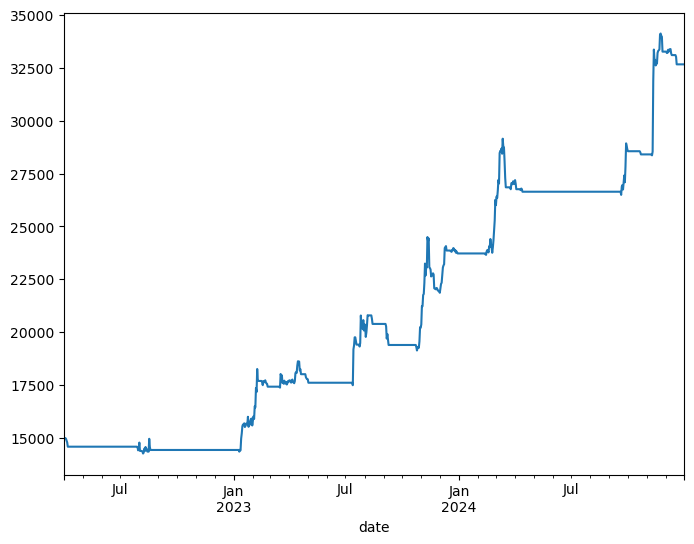

In [247]:
df_final_prod_config_backtested_expanded_alt_universe['total_portfolio_value'].plot(figsize=(8,6))

<Axes: xlabel='date'>

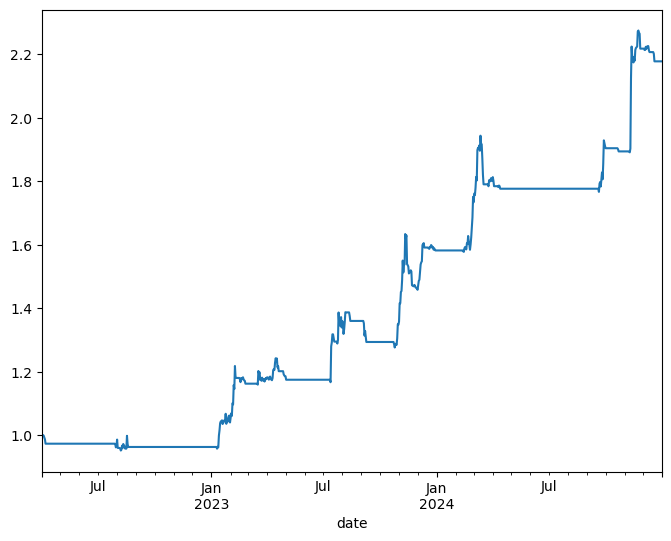

In [249]:
df_final_prod_config_backtested_expanded_alt_universe['equity_curve'].plot(figsize=(8,6))

<Axes: xlabel='date'>

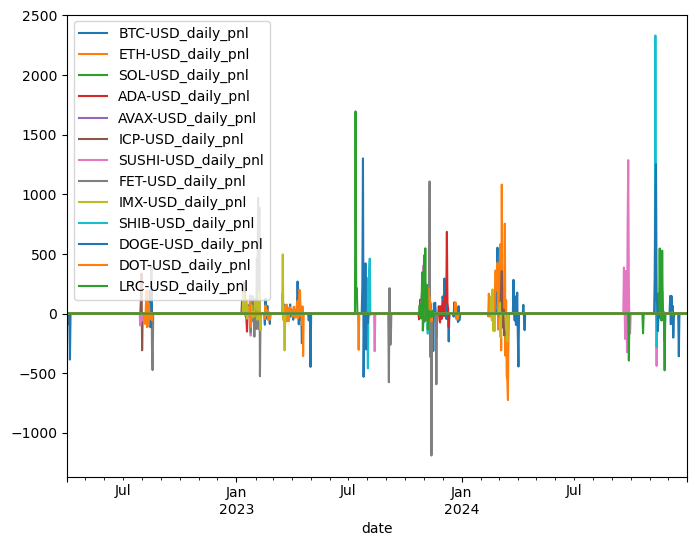

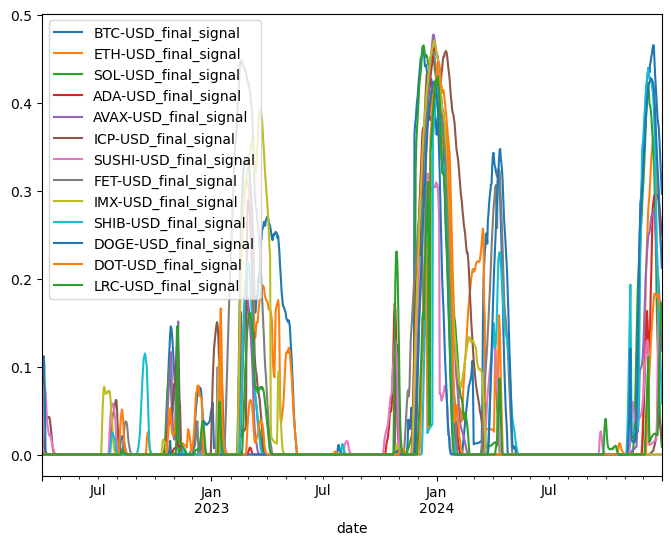

In [251]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in expanded_universe_list]
df_final_prod_config_backtested_expanded_alt_universe[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in expanded_universe_list]
df_final_prod_config_backtested_expanded_alt_universe[final_signal_cols].plot(figsize=(8,6))

In [253]:
## Higher Vol Target (0.90)
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
# defi_ticker_list_4 = ['CRV-USD','BAL-USD','1INCH-USD','DIA-USD']
expanded_universe_list = core_tickers + alt_universe_static
df_final_prod_config_backtested_expanded_alt_universe_higher_vol = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=expanded_universe_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=0.90,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_prod_config_backtested_expanded_alt_universe_higher_vol = df_final_prod_config_backtested_expanded_alt_universe_higher_vol[df_final_prod_config_backtested_expanded_alt_universe_higher_vol.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config_backtested_expanded_alt_universe_higher_vol = perf.calculate_asset_level_returns(df_final_prod_config_backtested_expanded_alt_universe_higher_vol, end_date_test, expanded_universe_list)

portfolio_perf_metrics_expanded_alt_universe_higher_vol = calculate_risk_and_performance_metrics(df_final_prod_config_backtested_expanded_alt_universe_higher_vol, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                                 strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_expanded_alt_universe_higher_vol

Generating Moving Average Ribbon Signal!!


KeyboardInterrupt: 

<Axes: xlabel='date'>

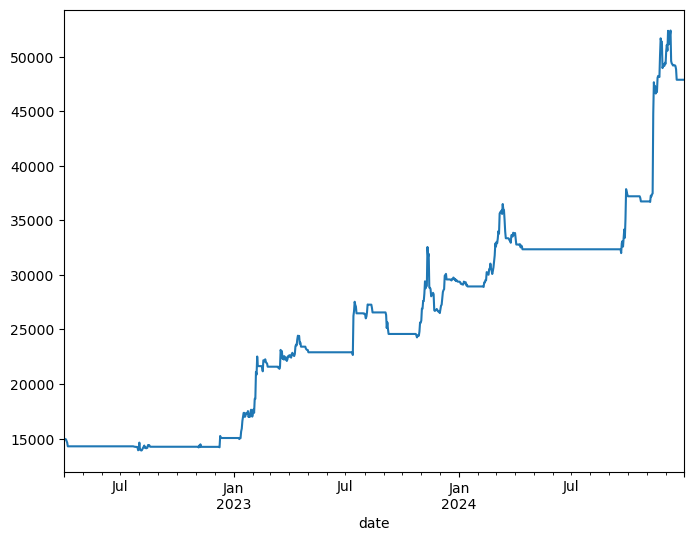

In [310]:
df_final_prod_config_backtested_expanded_alt_universe_higher_vol['total_portfolio_value'].plot(figsize=(8,6))

<Axes: xlabel='date'>

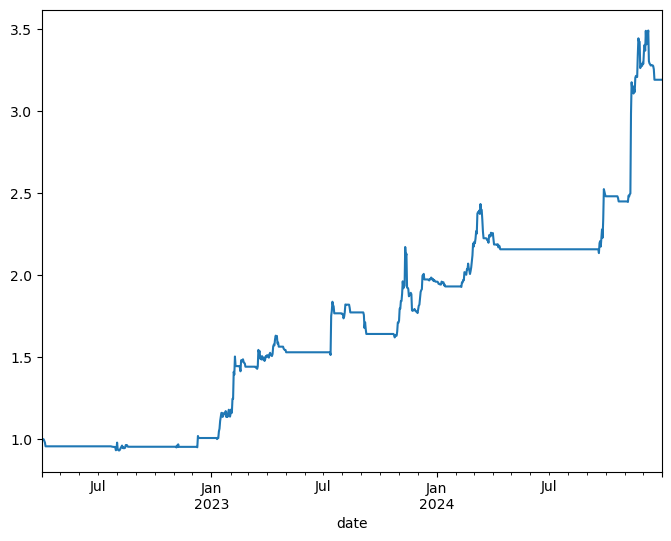

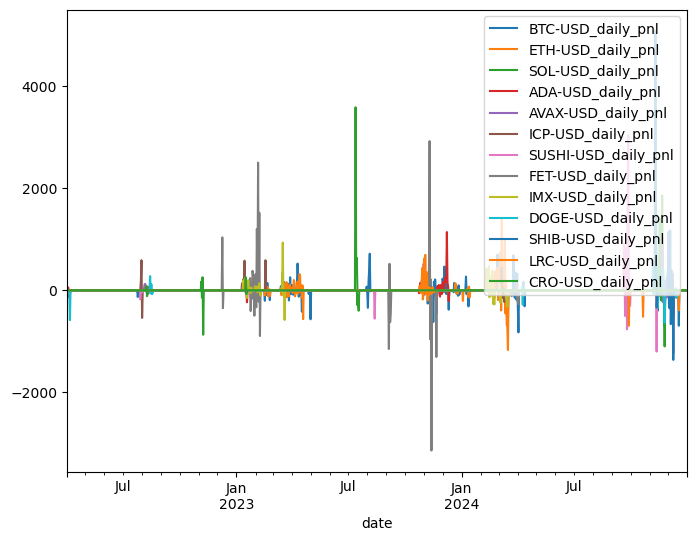

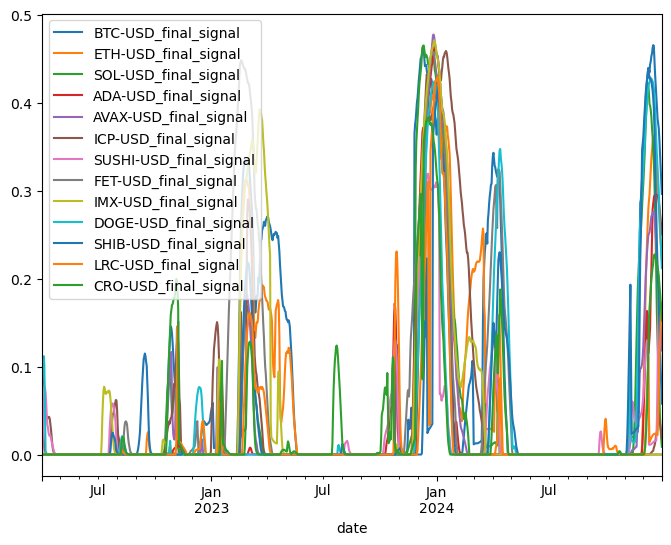

In [312]:
df_final_prod_config_backtested_expanded_alt_universe_higher_vol['equity_curve'].plot(figsize=(8,6))

daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in expanded_universe_list]
df_final_prod_config_backtested_expanded_alt_universe_higher_vol[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in expanded_universe_list]
df_final_prod_config_backtested_expanded_alt_universe_higher_vol[final_signal_cols].plot(figsize=(8,6))

### Rolling Sharpe & Performance Driven Alt Ticker Selection

In [335]:
sleeves.keys()

dict_keys(['core_L1_run1', 'L1_run2', 'L1_run3', 'L1_large', 'L2_run1', 'DeFi_run1', 'DeFi_run2', 'DeFi_run3', 'DeFi_run4'])

In [365]:
# Start from one sleeve and outer-join others
df_all = None
for name, df in sleeves.items():
    print(name)
    if name == 'L1_large':
        continue
    else:
        asset_cols = [c for c in df.columns if c.endswith(ASSET_RET_SUFFIX) and c != 'portfolio_daily_pct_returns']
        sub = df[asset_cols]
        if df_all is None:
            df_all = sub.copy()
        else:
            if ('ADA-USD_daily_pct_returns' in df_all.columns) & ('ADA-USD_daily_pct_returns' in sub.columns):
                sub = sub.drop(['ADA-USD_daily_pct_returns'], axis=1)
            df_all = df_all.join(sub, how="outer")
        
df_all = df_all.sort_index()
all_tickers = sorted({c.replace(ASSET_RET_SUFFIX, "") for c in df_all.columns})


core_L1_run1
L1_run2
L1_run3
L1_large
L2_run1
DeFi_run1
DeFi_run2
DeFi_run3
DeFi_run4


In [367]:
all_tickers

['1INCH-USD',
 'AAVE-USD',
 'ADA-USD',
 'ALGO-USD',
 'AMP-USD',
 'ATOM-USD',
 'AVAX-USD',
 'BAL-USD',
 'BTC-USD',
 'COMP-USD',
 'CRO-USD',
 'CRV-USD',
 'DIA-USD',
 'DOGE-USD',
 'DOT-USD',
 'ETH-USD',
 'FET-USD',
 'FIL-USD',
 'GRT-USD',
 'ICP-USD',
 'IMX-USD',
 'KRL-USD',
 'LINK-USD',
 'LRC-USD',
 'MANA-USD',
 'MKR-USD',
 'OXT-USD',
 'REQ-USD',
 'SHIB-USD',
 'SKL-USD',
 'SNX-USD',
 'SOL-USD',
 'STX-USD',
 'SUSHI-USD',
 'UNI-USD',
 'XLM-USD',
 'XTZ-USD']

In [413]:
def compute_rolling_coin_sharpe(df, ticker_list,
                                window_days=180,
                                ret_suffix=ASSET_RET_SUFFIX,
                                ann_days=ANN_DAYS, annual_rf=0.05):
    """
    Returns a MultiIndex Series: index=(date, ticker), value=rolling Sharpe.
    """
    daily_rf = (1 + annual_rf) ** (1/ann_days) - 1
    frames = []
    for t in ticker_list:
        col = f"{t}{ret_suffix}"
        if col not in df.columns:
            continue
        r = df[col].dropna()
        if r.empty:
            continue
        
        excess_returns = r - daily_rf
        roll_mu = excess_returns.rolling(window_days).mean()
        roll_sig = excess_returns.rolling(window_days).std()
        roll_sharpe = (roll_mu / roll_sig) * np.sqrt(ann_days)

        s = roll_sharpe.to_frame("rolling_sharpe")
        s["ticker"] = t
        frames.append(s)

    out = pd.concat(frames)
    out = out.reset_index().set_index(["date", "ticker"]).sort_index()
    out.index.names = ["date", "ticker"]
    out = out.replace([np.inf, -np.inf], np.nan)
    return out["rolling_sharpe"]

rolling_sharpe = compute_rolling_coin_sharpe(df_all, all_tickers, window_days=180)


In [415]:
rolling_sharpe

date        ticker   
2022-04-01  1INCH-USD           NaN
            AAVE-USD            NaN
            ADA-USD             NaN
            ALGO-USD            NaN
            AMP-USD             NaN
            ATOM-USD            NaN
            AVAX-USD            NaN
            BAL-USD             NaN
            BTC-USD             NaN
            COMP-USD            NaN
            CRO-USD             NaN
            CRV-USD             NaN
            DIA-USD             NaN
            DOGE-USD            NaN
            DOT-USD             NaN
            ETH-USD             NaN
            FET-USD             NaN
            FIL-USD             NaN
            GRT-USD             NaN
            ICP-USD             NaN
            IMX-USD             NaN
            KRL-USD             NaN
            LINK-USD            NaN
            LRC-USD             NaN
            MANA-USD            NaN
            MKR-USD             NaN
            OXT-USD             NaN
      

In [417]:
def build_alt_universe_by_month(rolling_sharpe,
                                core_tickers,
                                sharpe_threshold=0.0,
                                max_alts=8):
    """
    rolling_sharpe: Series indexed by (date, ticker)
    """
    alt_universe_by_month = {}

    dates = rolling_sharpe.index.get_level_values("date")
    month_ends = pd.to_datetime(dates).to_period("M").to_timestamp("M").unique()

    for me in month_ends:
        try:
            rs_me = rolling_sharpe.xs(me, level="date")
        except KeyError:
            continue

        rs_df = rs_me.reset_index()
        rs_df = rs_df[~rs_df["ticker"].isin(core_tickers)]

        # Filter by Sharpe threshold
        rs_df = rs_df[rs_df["rolling_sharpe"] > sharpe_threshold]

        rs_df = rs_df.sort_values("rolling_sharpe", ascending=False)
        selected = rs_df["ticker"].head(max_alts).tolist()
        alt_universe_by_month[me.date()] = selected

    return alt_universe_by_month

alt_universe_by_month = build_alt_universe_by_month(
    rolling_sharpe,
    core_tickers=core_tickers,
    sharpe_threshold=0.0,
    max_alts=8,
)

list(alt_universe_by_month.items())[:5]  # peek at first few months


[(datetime.date(2022, 4, 30), []),
 (datetime.date(2022, 5, 31), []),
 (datetime.date(2022, 6, 30), []),
 (datetime.date(2022, 7, 31), []),
 (datetime.date(2022, 8, 31), [])]

In [453]:
alt_universe_by_month

{datetime.date(2022, 4, 30): [],
 datetime.date(2022, 5, 31): [],
 datetime.date(2022, 6, 30): [],
 datetime.date(2022, 7, 31): [],
 datetime.date(2022, 8, 31): [],
 datetime.date(2022, 9, 30): ['LINK-USD', 'ATOM-USD'],
 datetime.date(2022, 10, 31): ['LINK-USD', 'ATOM-USD'],
 datetime.date(2022, 11, 30): ['LINK-USD', 'ATOM-USD'],
 datetime.date(2022, 12, 31): ['LINK-USD', 'ATOM-USD', 'FET-USD'],
 datetime.date(2023, 1, 31): ['ICP-USD',
  'AMP-USD',
  'IMX-USD',
  'LINK-USD',
  'GRT-USD',
  'SHIB-USD',
  'ATOM-USD',
  'FET-USD'],
 datetime.date(2023, 2, 28): ['ICP-USD',
  'AMP-USD',
  'FET-USD',
  'GRT-USD',
  'IMX-USD',
  'SHIB-USD',
  'ATOM-USD'],
 datetime.date(2023, 3, 31): ['ICP-USD',
  'AMP-USD',
  'FET-USD',
  'GRT-USD',
  'IMX-USD',
  'SHIB-USD'],
 datetime.date(2023, 4, 30): ['ICP-USD',
  'AMP-USD',
  'FET-USD',
  'GRT-USD',
  'IMX-USD',
  'SHIB-USD'],
 datetime.date(2023, 5, 31): ['ICP-USD',
  'AMP-USD',
  'FET-USD',
  'GRT-USD',
  'IMX-USD',
  'SHIB-USD',
  'AAVE-USD'],
 date

In [419]:
dates = rolling_sharpe.index.get_level_values("date")
month_ends = pd.to_datetime(dates).to_period("M").to_timestamp("M").unique()
for me in month_ends:
    try:
        rs_me = rolling_sharpe.xs(me, level="date")
    except KeyError:
        continue

In [437]:
rs_df = rs_me.reset_index()
rs_df = rs_df[~rs_df["ticker"].isin(core_tickers)]

In [445]:
sharpe_threshold=0.0
max_alts = 8
# Filter by Sharpe threshold
rs_df = rs_df[rs_df["rolling_sharpe"] > sharpe_threshold]
rs_df = rs_df.sort_values("rolling_sharpe", ascending=False)

selected = rs_df["ticker"].head(max_alts).tolist()
alt_universe_by_month[me.date()] = selected

In [447]:
selected

['DOGE-USD',
 'SUSHI-USD',
 'CRO-USD',
 'DIA-USD',
 'UNI-USD',
 'KRL-USD',
 'SHIB-USD',
 'IMX-USD']

In [441]:
rs_df

ticker  rolling_sharpe
13   DOGE-USD        2.977465
33  SUSHI-USD        2.041214
10    CRO-USD        1.679405
12    DIA-USD        1.645843
34    UNI-USD        1.484698
21    KRL-USD        1.298607
28   SHIB-USD        1.207750
20    IMX-USD        1.184499
24   MANA-USD        0.713795
23    LRC-USD        0.706450
19    ICP-USD        0.427036

In [429]:
rs_df

ticker  rolling_sharpe
0   1INCH-USD             NaN
1    AAVE-USD       -0.632456
3    ALGO-USD       -2.069471
4     AMP-USD             NaN
5    ATOM-USD       -2.362082
7     BAL-USD       -2.745101
9    COMP-USD             NaN
10    CRO-USD        1.679405
11    CRV-USD       -2.502975
12    DIA-USD        1.645843
13   DOGE-USD        2.977465
14    DOT-USD             NaN
16    FET-USD             NaN
17    FIL-USD             NaN
18    GRT-USD       -2.926906
19    ICP-USD        0.427036
20    IMX-USD        1.184499
21    KRL-USD        1.298607
22   LINK-USD             NaN
23    LRC-USD        0.706450
24   MANA-USD        0.713795
25    MKR-USD             NaN
26    OXT-USD       -2.735401
27    REQ-USD             NaN
28   SHIB-USD        1.207750
29    SKL-USD       -0.149659
30    SNX-USD       -3.224864
32    STX-USD             NaN
33  SUSHI-USD        2.041214
34    UNI-USD        1.484698
35    XLM-USD       -3.541842
36    XTZ-USD      -12.870073

In [421]:
month_ends

DatetimeIndex(['2022-04-30', '2022-05-31', '2022-06-30', '2022-07-31',
               '2022-08-31', '2022-09-30', '2022-10-31', '2022-11-30',
               '2022-12-31', '2023-01-31', '2023-02-28', '2023-03-31',
               '2023-04-30', '2023-05-31', '2023-06-30', '2023-07-31',
               '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
               '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31',
               '2024-04-30', '2024-05-31', '2024-06-30', '2024-07-31',
               '2024-08-31', '2024-09-30', '2024-10-31', '2024-11-30',
               '2024-12-31'],
              dtype='datetime64[ns]', name='date', freq=None)

In [425]:
me

Timestamp('2024-12-31 00:00:00')

In [423]:
rs_me

ticker
1INCH-USD          NaN
AAVE-USD     -0.632456
ADA-USD      -2.863694
ALGO-USD     -2.069471
AMP-USD            NaN
ATOM-USD     -2.362082
AVAX-USD     -0.655046
BAL-USD      -2.745101
BTC-USD       1.315394
COMP-USD           NaN
CRO-USD       1.679405
CRV-USD      -2.502975
DIA-USD       1.645843
DOGE-USD      2.977465
DOT-USD            NaN
ETH-USD      -4.876602
FET-USD            NaN
FIL-USD            NaN
GRT-USD      -2.926906
ICP-USD       0.427036
IMX-USD       1.184499
KRL-USD       1.298607
LINK-USD           NaN
LRC-USD       0.706450
MANA-USD      0.713795
MKR-USD            NaN
OXT-USD      -2.735401
REQ-USD            NaN
SHIB-USD      1.207750
SKL-USD      -0.149659
SNX-USD      -3.224864
SOL-USD       0.517342
STX-USD            NaN
SUSHI-USD     2.041214
UNI-USD       1.484698
XLM-USD      -3.541842
XTZ-USD     -12.870073
Name: rolling_sharpe, dtype: float64

## Sleeve Level Portfolio Optimization

In [ ]:
sleeves_for_opt = ["core_L1_run1", "L1_run2", "L1_run3", "DeFi_run1", "DeFi_run2"]

mu = sleeve_ret[sleeves_for_opt].mean() * ANN_DAYS        # annualized mean
cov = sleeve_ret[sleeves_for_opt].cov() * ANN_DAYS        # annualized cov

def sharpe_for_w(w, mu, cov):
    w = np.asarray(w)
    ann_ret = w @ mu.values
    ann_vol = np.sqrt(w @ cov.values @ w)
    return ann_ret / ann_vol

# simple constrained grid search over core weight & alt splits
best = None
for w_core in np.linspace(0.6, 0.9, 7):         # 0.60 ... 0.90
    remaining = 1 - w_core
    # split remaining evenly across selected alts for now
    k = len(sleeves_for_opt) - 1
    w_alt = remaining / k
    w = np.array([w_core] + [w_alt] * (k))
    s = sharpe_for_w(w, mu, cov)
    if (best is None) or (s > best[0]):
        best = (s, w)

best_sharpe, best_w = best
dict(zip(sleeves_for_opt, best_w)), best_sharpe


In [458]:
sleeve_ret['core_L1_run1'].head()

date
2022-04-01    0.000000
2022-04-02   -0.005886
2022-04-03   -0.003868
2022-04-04    0.011847
2022-04-05    0.010064
Freq: D, Name: core_L1_run1, dtype: float64

## Prod Config Performance Monitoring

In [341]:
end_date

datetime.date(2025, 11, 30)

In [361]:
df_final_prod_config = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=False, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_prod_config = df_final_prod_config[df_final_prod_config.index >= pd.Timestamp(start_date)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config = perf.calculate_asset_level_returns(df_final_prod_config, end_date, ticker_list)

portfolio_perf_metrics_prod_config = calculate_risk_and_performance_metrics(df_final_prod_config, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 6.10939092233199,
 'annualized_sharpe_ratio': 2.2597828554180754,
 'calmar_ratio': 44.90392418803005,
 'annualized_std_dev': 0.7851141398791063,
 'max_drawdown': -0.13605472200491017,
 'max_drawdown_duration': Timedelta('120 days 00:00:00'),
 'hit_rate': 0.2380597014925373,
 't_statistic': 4.421514807482555,
 'p_value': 1.0593971339640123e-05,
 'trade_count': 279.0}

In [362]:
df_final_prod_config.tail(5)

BTC-USD_20_avg_true_range_price  BTC-USD_actual_position_notional  \
date                                                                            
2025-11-26                      4196.577293                               0.0   
2025-11-27                      4212.291836                               0.0   
2025-11-28                      3988.034518                               0.0   
2025-11-29                      3888.351231                               0.0   
2025-11-30                      3613.269209                               0.0   

            BTC-USD_actual_position_size  BTC-USD_annualized_volatility_30  \
date                                                                         
2025-11-26                           0.0                          0.422514   
2025-11-27                           0.0                          0.450318   
2025-11-28                           0.0                          0.453949   
2025-11-29                           0.0                          0.448948   
2025-11-30                           0.0                          0.447941   

            BTC-USD_close  BTC-USD_cooldown_counter  \
date                                                  
2025-11-26       90468.84                       0.0   
2025-11-27       91316.70                       0.0   
2025-11-28       90902.70                       0.0   
2025-11-29       90828.06                       0.0   
2025-11-30       91520.02                       0.0   

                                  BTC-USD_event  BTC-USD_final_signal  \
date                                                                    
2025-11-26                          No Position         -3.188687e-28   
2025-11-27  Entry Blocked by Chandelier (Short)         -1.574332e-28   
2025-11-28  Entry Blocked by Chandelier (Short)         -1.001082e-02   
2025-11-29  Entry Blocked by Chandelier (Short)         -2.333938e-02   
2025-11-30  Entry Blocked by Chandelier (Short)         -3.977127e-02   

            BTC-USD_final_weighted_additive_signal  BTC-USD_highest_high_56  \
date                                                                          
2025-11-26                               -0.484985                 126296.0   
2025-11-27                               -0.478897                 126296.0   
2025-11-28                               -0.473371                 126296.0   
2025-11-29                               -0.470623                 126296.0   
2025-11-30                               -0.468861                 126296.0   

            BTC-USD_lowest_low_56  BTC-USD_new_position_entry_exit_price  \
date                                                                       
2025-11-26               80524.65                               87325.00   
2025-11-27               80524.65                               90468.83   
2025-11-28               80524.65                               91316.70   
2025-11-29               80524.65                               90902.69   
2025-11-30               80524.65                               90829.68   

            BTC-USD_new_position_notional  BTC-USD_new_position_size  \
date                                                                   
2025-11-26                            0.0                        0.0   
2025-11-27                            0.0                        0.0   
2025-11-28                            0.0                        0.0   
2025-11-29                            0.0                        0.0   
2025-11-30                            0.0                        0.0   

            BTC-USD_open  BTC-USD_open_position_notional  \
date                                                       
2025-11-26      87325.00                             0.0   
2025-11-27      90468.83                             0.0   
2025-11-28      91316.70                             0.0   
2025-11-29      90902.69                             0.0   
2025-11-30      90829.68                       

<Axes: xlabel='date'>

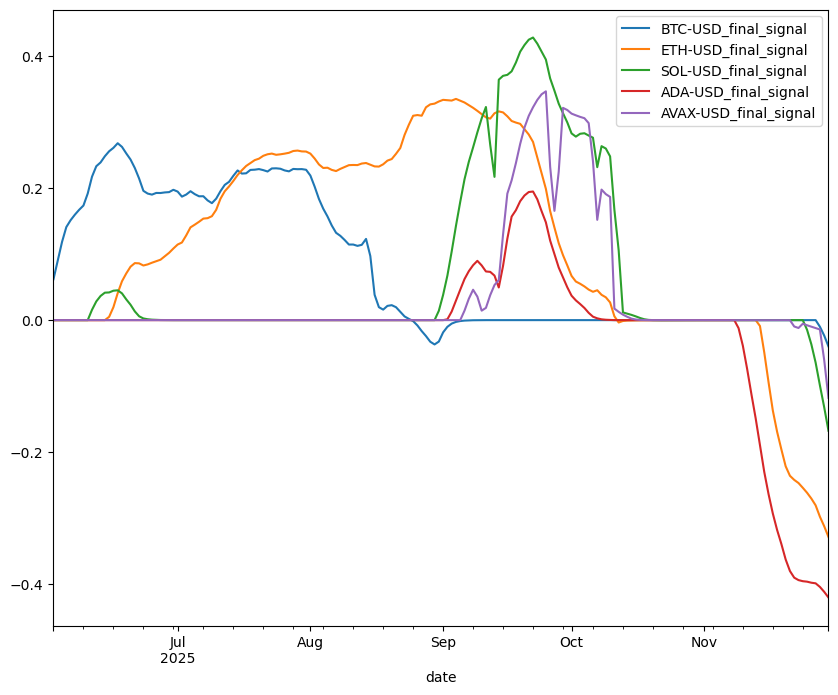

In [363]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][final_signal_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

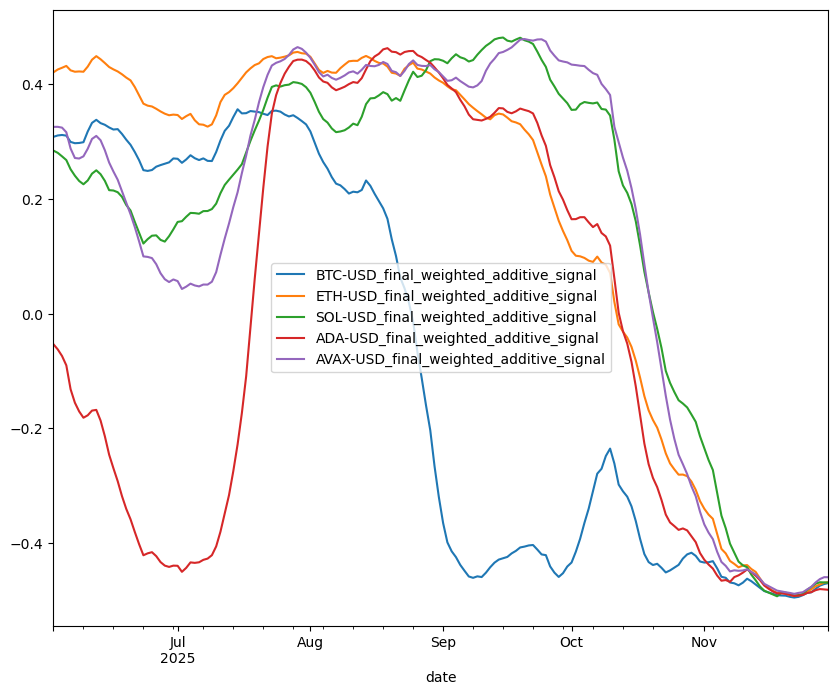

In [349]:
raw_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][raw_signal_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

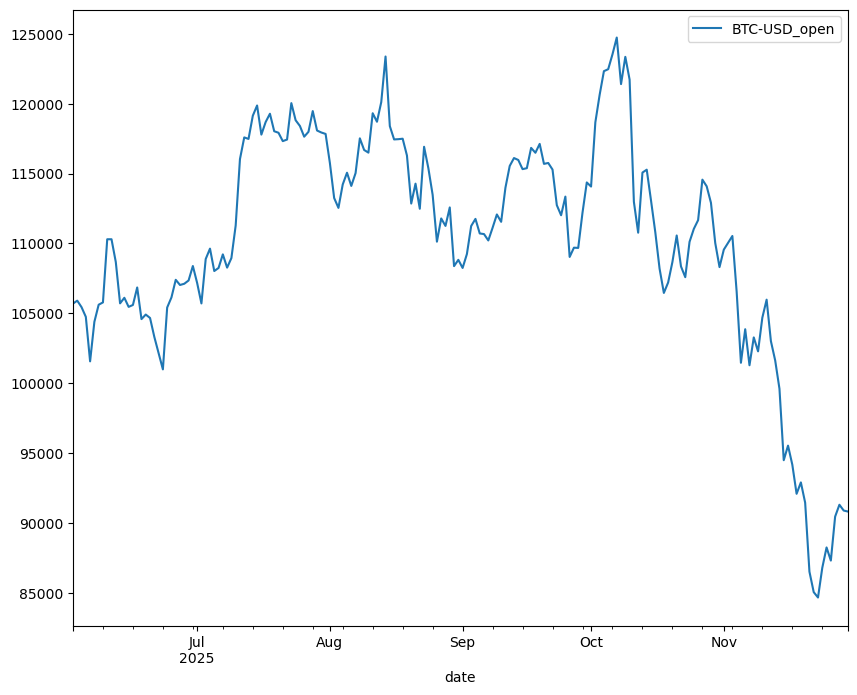

In [351]:
open_cols = [f'{ticker}_open' for ticker in ['BTC-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

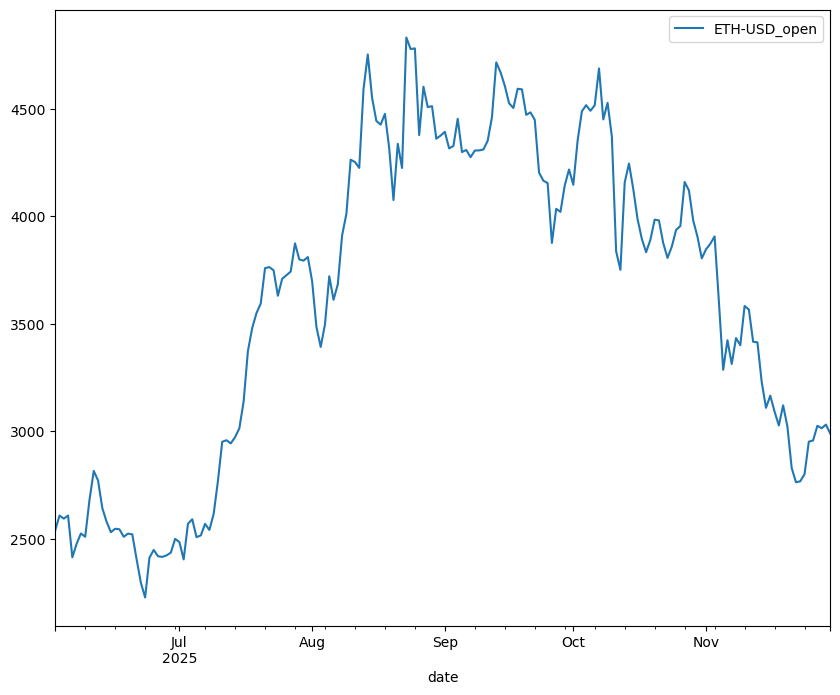

In [353]:
open_cols = [f'{ticker}_open' for ticker in ['ETH-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

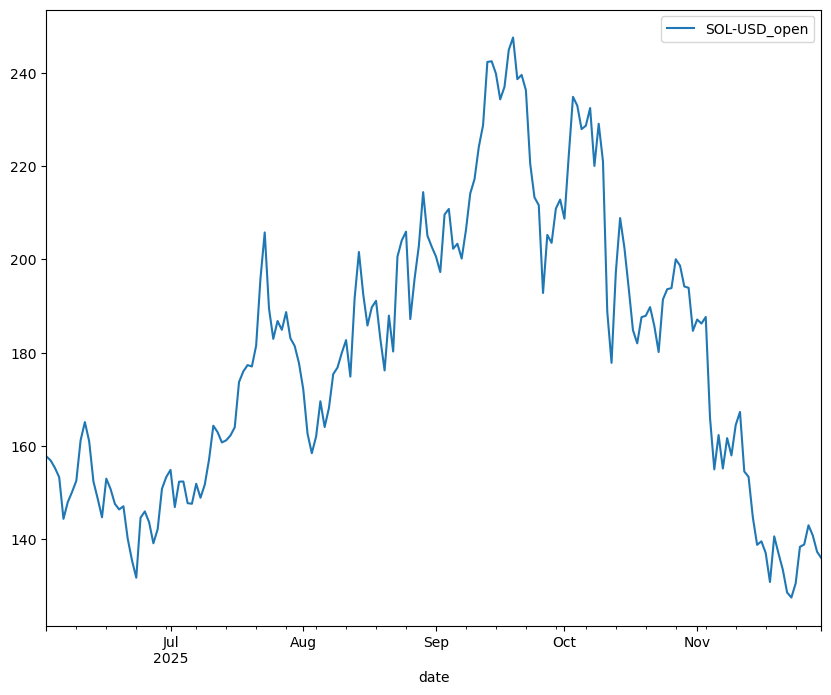

In [354]:
open_cols = [f'{ticker}_open' for ticker in ['SOL-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

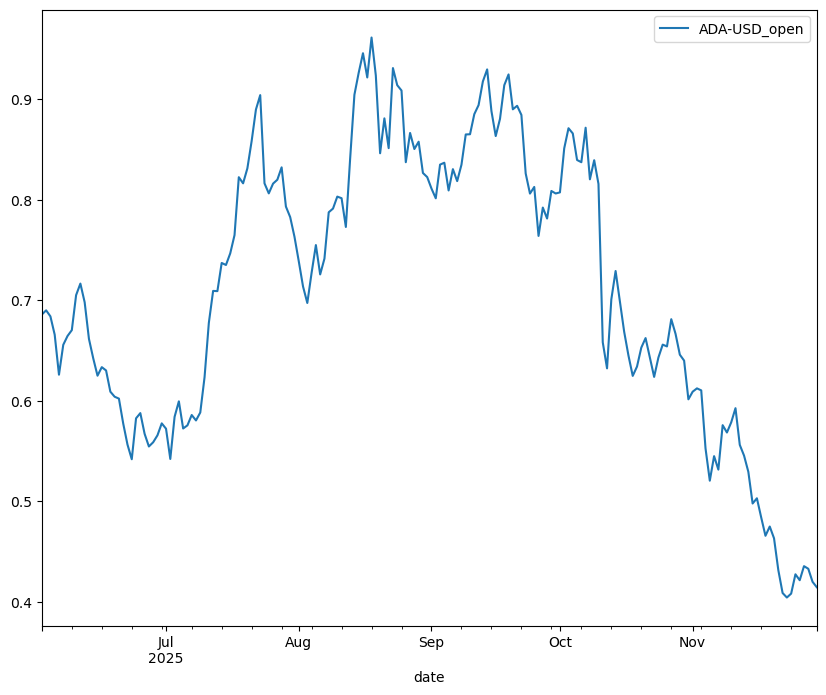

In [357]:
open_cols = [f'{ticker}_open' for ticker in ['ADA-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

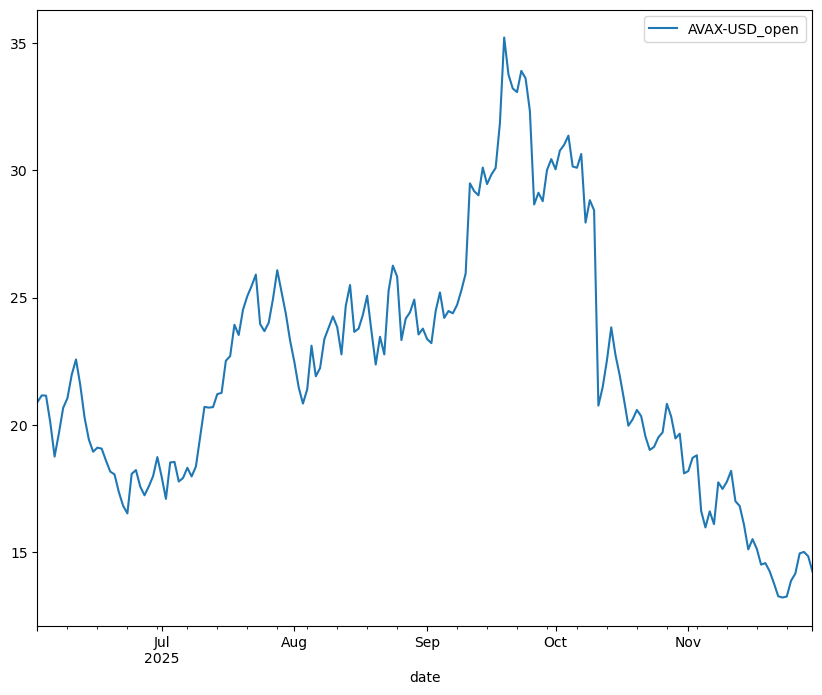

In [359]:
open_cols = [f'{ticker}_open' for ticker in ['AVAX-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))